<h1>ZMGSN Lista 5. - Architektura Sieci typu Transformer</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem sieci typu Transformer</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki sieci typu Transformer (10pkt)</li>
<li>Wykorzystać inne architektury wstępnie wyuczonych sieci typu Transformer (np. RoBERTa, XLM-RoBERTa, DistilBERT, AlBERT, DeBERTa, XLNet, MPNet, LaBSE itp.) w celu uzasadnienia w jaki sposób ich architektura, sposób uczenia i zbiór uczący mogły mieć wpływ na wyniki (30pkt)</li>
<li>Wykorzystać inne rozmiary wstępnie wyuczonych sieci typu Transformer w celu uzasadnienia w jaki sposób ich architektura, sposób uczenia i zbiór uczący mogły mieć wpływ na wyniki - porównać modele o tej samej architekturze, ale różnych rozmiarach np. (XLM-RoBERTa-base, XLM-RoBERTa-large) (20pkt)</li>
<li>Dokonać modyfikacji rozszerzenia wstępnie wyuczonej sieci typu Transformer w celu zbadania wpływu architektury na wyniki (5pkt)</li>
<li>Zaimplementować własne warianty rozszerzeń architektury wstępnie wyuczonej sieci typu Transformer w celu zbadania ich wpływu na wyniki (15pkt)</li>
<li>Zbadać wpływ maksymalnej długości tekstu oraz różnych strategii paddingu dla każdego z wykorzystanych wstępnie wyuczonych modeli (20 pkt)</li>
<li>Dokonać ewaluacji różnych wstępnie wyuczonych modeli sieci typu Transformer (różne rozmiary modeli oraz typy), modyfikacji oryginalnego rozszerzenia oraz opracowanych rozszerzeń zgodnie z punktami 2., 5., 6. i 7.  </li>
<li>Dokonać usystematyzowanej ewaluacji porównawczej wszystkich modeli sieci typu transformer, ich wariantów, wykorzystanych rozszerzeń w celu zbadania różnic, podobieństw oraz analogicznych cech ich charakterystyki.</li>
<li>Opracować procedurę ewaluacji jakości działania modeli sieci typu Transformer, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE), walidacji krzyżowej, wpływu charakterystyki zbioru uczącego na działanie modelu, podatności na semantykę tekstów w zbiorze uczącym i testowym itp. </li>
</ol>

Należy przygotować raport w LaTeX, który będzie zawierać opis architektury typu Transformer, opis wybranych architektur, opis wykonanych eksperymentów, opis procedury ewaluacji, wyniki ewaluacji oraz wnioski. Ocena za raport będzie stanowić 50% oceny za listę. Maksymalna liczba punktów za każde zadanie będzie przyznana za implementację oraz kompletny opis w raporcie. Punkty za zadania 2-7 będą przyznane za implementację oraz ewaluację. 
 
Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
<li>Raport </li>
</ol>


<h2>Import używanych bibliotek</h2>

In [18]:
import os

import gdown
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from transformers import RobertaModel, MPNetModel,AlbertModel, XLNetModel, DistilBertModel
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns

<h2>Inicjalizacja ziarna generatora liczb pseudolosowych</h2>

In [2]:
torch.manual_seed(0)

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [3]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


<h2>Pobranie i rozpakowanie zbioru danych</h2>

In [4]:
if os.path.exists('data.csv'):
  os.remove('data.csv')

In [5]:
url = 'https://drive.google.com/uc?id=1HSnB-D0dKDI2bE9iOsp-Vr8tumihdvbH'
output = 'data.csv'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1HSnB-D0dKDI2bE9iOsp-Vr8tumihdvbH
To: c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\data.csv
100%|██████████| 467k/467k [00:00<00:00, 4.83MB/s]


'data.csv'

<h2>Wczytanie zbioru danych</h2>

In [4]:
df = pd.read_csv('data.csv')
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


<h2>Podział zbioru na podzbiór uczący i testowy</h2>

In [5]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

<h2>Pobranie modelu wstępnie wyuczonej sieci typu Transformer</h2>

In [49]:
# Pobranie oraz wczytanie modelu transformera
pretrained_model = AutoModel.from_pretrained('bert-base-uncased')

# Pobranie oraz wczytanie dedykowanego tokenizatora
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

<h2>Tokenizacja oraz wygenerowanie wektorowych reprezentacji tekstów</h2>

In [50]:
# Tokenizacja i wygenerowanie reprezentacji wektorowych tekstów ze zbioru uczącego
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding='max_length',
    truncation=True
)

# Tokenizacja i wygenerowanie reprezentacji wektorowych tekstów ze zbioru walidacyjnego
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    padding='max_length',
    truncation=True
)

# Tokenizacja i wygenerowanie reprezentacji wektorowych tekstów ze zbioru testowego
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding='max_length',
    truncation=True
)

<h2>Konwersja list na tensory</h2>

In [51]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

<h2>Przygotowanie instancji klas typu DataLoader</h2>

In [52]:
# Określenie rozmiaru pakietu (ang. batch size)
batch_size = 8

# Utworzenie obiektu klasy nadrzędnej dla zbiorów: uczącego, walidacyjnego i teestowego
train_data = TensorDataset(train_seq, train_mask, train_y)

# Przygotowanie obiektu klasy pozwalającej na próbkowanie zbioru uczącego
train_sampler = RandomSampler(train_data)

# Przygotowanie obhiektu klasy DataLoader dla zbioru uczącego
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Przygotowanie klasy nadrzędnej dla zbioru walidacyjnego
val_data = TensorDataset(val_seq, val_mask, val_y)

# Przygotowanie obiektu klasy pozwalającej na próbkowanie zbioru uczącego
val_sampler = SequentialSampler(val_data)

# Przygotowanie obhiektu klasy DataLoader dla zbioru walidacyjnego
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

<h2>Przygotowanie rozszerzenia architektury wstępnie wyuczonego modelu sieci typu Transformer</h2>

In [53]:
# Zamrozenie wszystkich parametrów pierwotnej sieci
for param in pretrained_model.parameters():
    param.requires_grad = False

In [11]:
class Ext_Arch(nn.Module):

    def __init__(self, pretrained_model):
        super(Ext_Arch, self).__init__()

        self.pretrained_model = pretrained_model

        self.dropout = nn.Dropout(0.1)

        self.relu =  nn.ReLU()

        self.fc1 = nn.Linear(768,512)

        self.fc2 = nn.Linear(512,2)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

        _, cls_hs = self.pretrained_model(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)

        x = self.softmax(x)

        return x

<h2>Konfiguracja eksperymentu</h2>

In [12]:
# Inicjalizacja rozszerzonej architektury pierwotnym modelem
model = Ext_Arch(pretrained_model)

# Przeniesienie modelu do pamięci domyślnego urządzenia
model = model.to(device)

In [13]:
# Inicjalizacja optymalizatora
optimizer = AdamW(model.parameters(),lr = 1e-5)

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Obliczenie wag klas
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:", class_weights)

Class Weights: [0.57743559 3.72848948]


In [15]:
# Konwersja listy z wagami klas do typu tensorowego
weights= torch.tensor(class_weights,dtype=torch.float)

# Przeniesienie wag do pamięci domyślnego urządzenia
weights = weights.to(device)

# Określenie funkcji straty
cross_entropy  = nn.NLLLoss(weight=weights)

# Określenie liczby epok
epochs = 10

<h2>Kalibracja modelu (ang. fine-tuning)</h2>

In [16]:
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # przygotowanie listy do przechowywania predykcji modelu
    total_preds=[]

    for step,batch in enumerate(train_dataloader):

        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        model.zero_grad()

        preds = model(sent_id, mask)

        loss = cross_entropy(preds, labels)

        total_loss = total_loss + loss.item()

        loss.backward()

        # Normalizacja wartości gradientów
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

        # Add these lines to free up memory
        del preds
        torch.cuda.empty_cache()

    # Continue with the rest of your code
    avg_loss = total_loss / len(train_dataloader)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [17]:
def evaluate():

    print("\nEvaluating...")

    model.eval()

    total_loss, total_accuracy = 0, 0

    total_preds = []

    for step,batch in enumerate(val_dataloader):

        if step % 50 == 0 and not step == 0:

            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        with torch.no_grad():

            preds = model(sent_id, mask)

            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)

    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [52]:
# Inicjalizacja początkowej wartości funkcji straty
best_valid_loss = float('inf')

# Inicjalizacja list na wartości funkcji straty na zbiorze uczącym i walidacyjnym
train_losses=[]
valid_losses=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()

    valid_loss, _ = evaluate()

    # zapisanie najlepszego modelu
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.673
Validation Loss: 0.649

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.641
Validation Loss: 0.623

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.619
Validation Loss: 0.595

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.594
Validation Loss: 0.568

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.570
Validation Loss: 0.544

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.550
Validation Loss: 0.533

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.527
Validation Loss: 0.499

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.508
Validat

In [53]:
# Wczytanie wartości parametrów najlepszego modelu
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

<h2>Wygenerowanie predykcji za pomocą skalibrowanego modelu oraz ocena ich jakości</h2>

In [54]:
# Wygenerowanie predykcji dla zbioru testowego
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [55]:
# Ocena jakości predykcji modelu
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       724
           1       0.40      0.88      0.54       112

    accuracy                           0.80       836
   macro avg       0.69      0.83      0.71       836
weighted avg       0.90      0.80      0.83       836



Zadanie 2

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.544
Validation Loss: 0.290

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.316
Validation Loss: 0.234

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.238
Validation Loss: 0.172

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.238
Validation Loss: 0.200

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.243
Validation Loss: 0.165

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.215
Validation Loss: 0.183

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.214
Validation Loss: 0.156

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.175
Validat

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.594
Validation Loss: 0.482

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.457
Validation Loss: 0.373

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.367
Validation Loss: 0.299

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.311
Validation Loss: 0.268

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.263
Validation Loss: 0.251

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.253
Validation Loss: 0.214

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.225
Validation Loss: 0.216

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.217
Validation Loss: 0.200

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.673
Validation Loss: 0.656

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.647
Validation Loss: 0.629

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.619
Validation Loss: 0.597

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.594
Validation Loss: 0.574

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.577
Validation Loss: 0.553

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.555
Validation Loss: 0.527

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.536
Validation Loss: 0.507

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.516
Validation Loss: 0.489

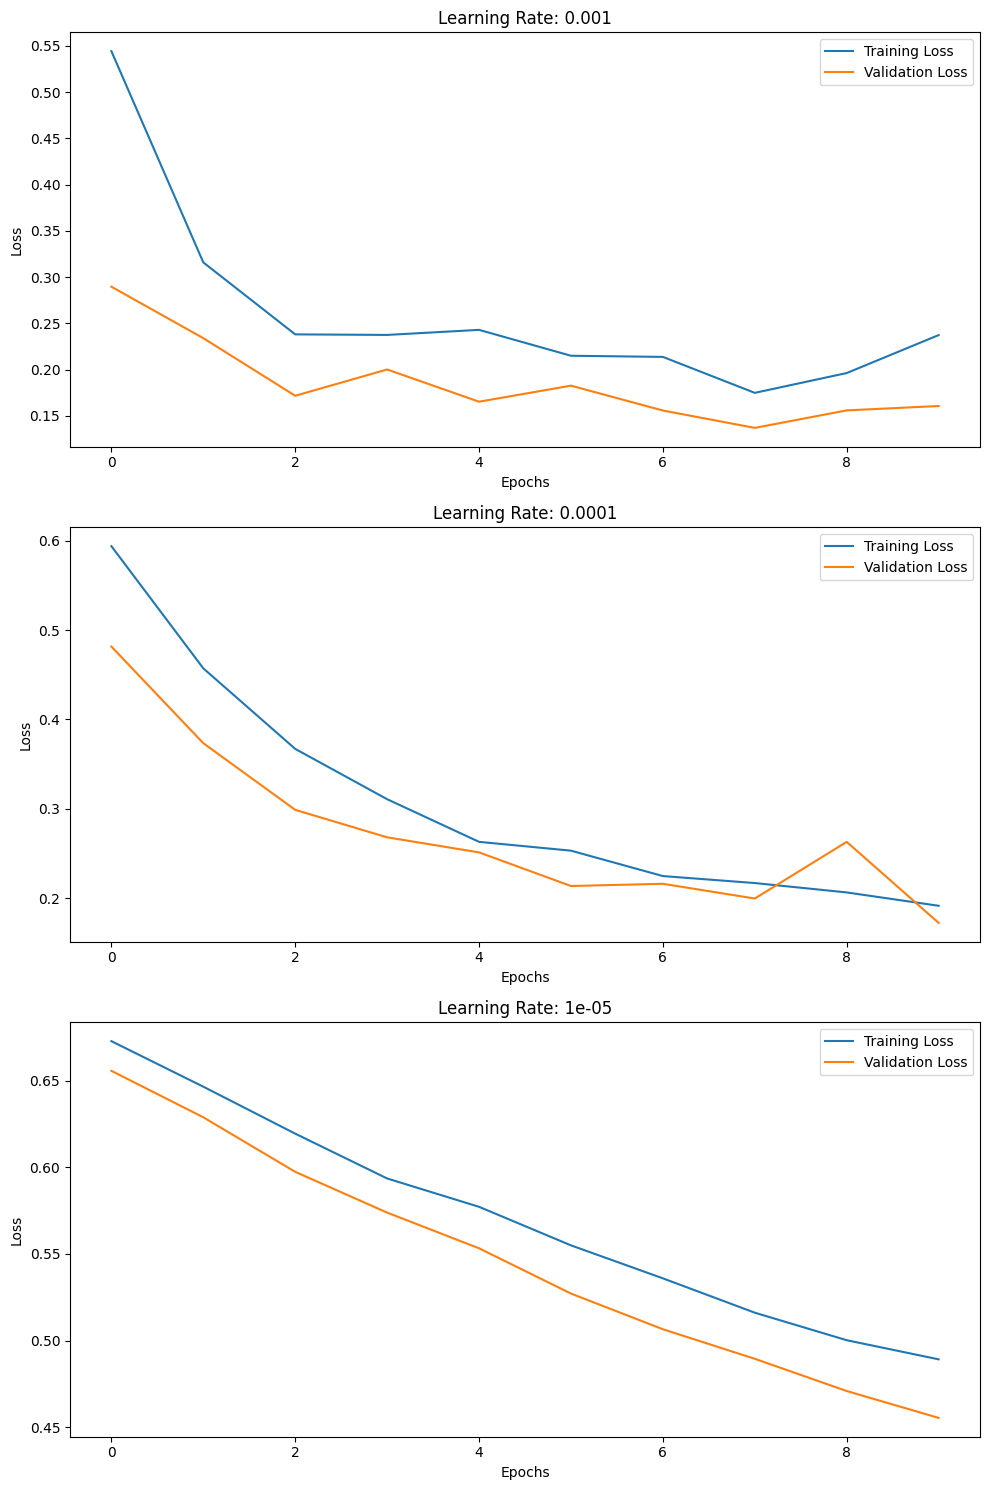

In [39]:
losses_dict = {}

learning_rates = [1e-3, 1e-4, 1e-5]
for lr in learning_rates:
    model = Ext_Arch(pretrained_model)
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    cross_entropy = nn.NLLLoss(weight=weights)

    epochs = 10
    best_valid_loss = float('inf')

    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

        train_loss, _ = train()
        valid_loss, _ = evaluate()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'saved_weights_lr_{lr}.pt')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')

    losses_dict[lr] = {'train': train_losses, 'valid': valid_losses}

fig, axs = plt.subplots(len(learning_rates), 1, figsize=(10, 15))
for i, lr in enumerate(learning_rates):
    axs[i].plot(losses_dict[lr]['train'], label='Training Loss')
    axs[i].plot(losses_dict[lr]['valid'], label='Validation Loss')
    axs[i].set_title(f'Learning Rate: {lr}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()


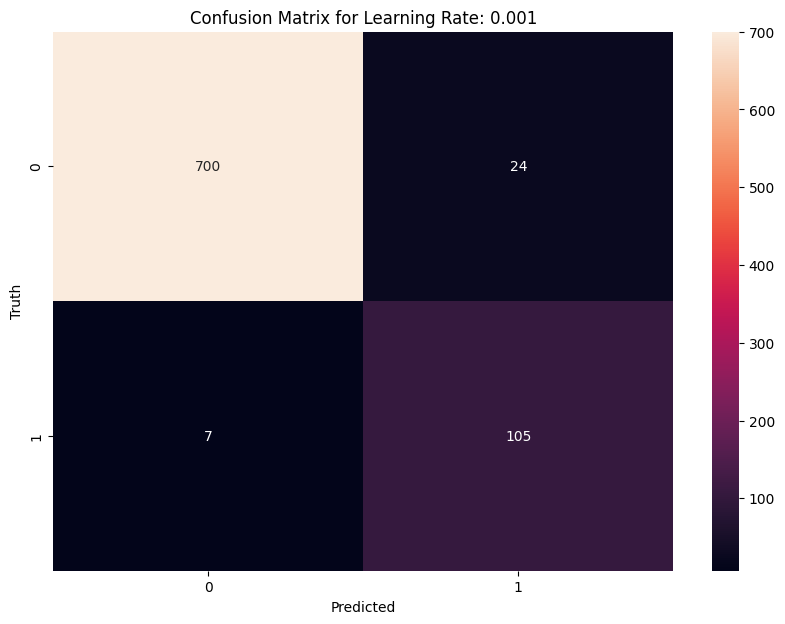


Classification Report for Learning Rate: 0.001
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       724
           1       0.81      0.94      0.87       112

    accuracy                           0.96       836
   macro avg       0.90      0.95      0.92       836
weighted avg       0.97      0.96      0.96       836



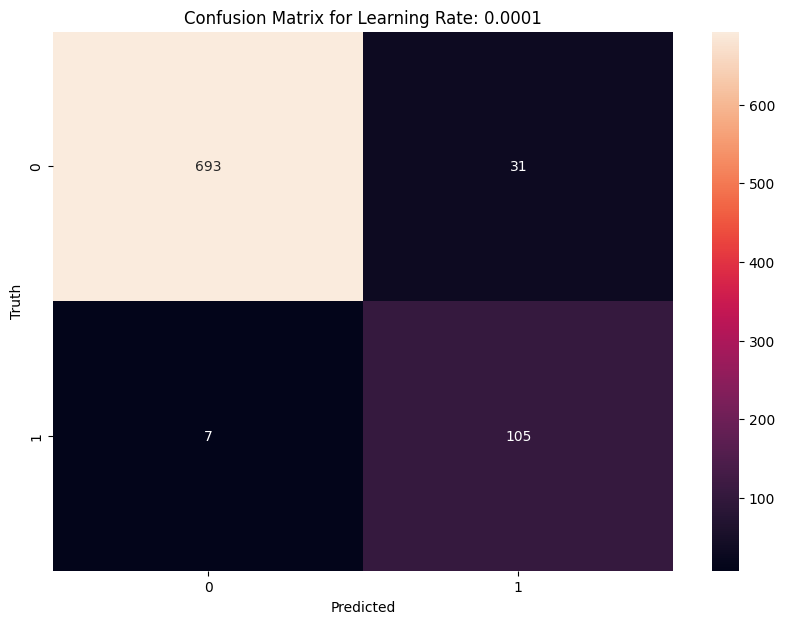


Classification Report for Learning Rate: 0.0001
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       724
           1       0.77      0.94      0.85       112

    accuracy                           0.95       836
   macro avg       0.88      0.95      0.91       836
weighted avg       0.96      0.95      0.96       836



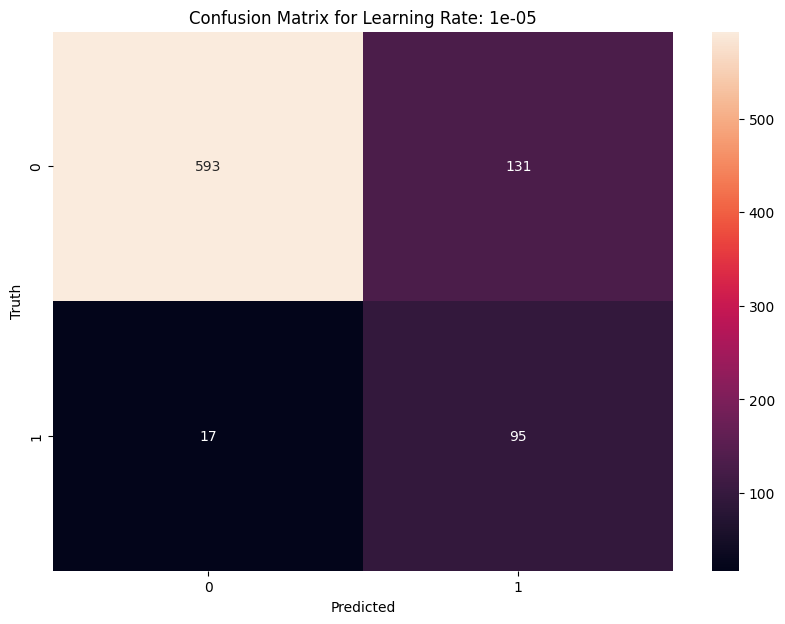


Classification Report for Learning Rate: 1e-05
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       724
           1       0.42      0.85      0.56       112

    accuracy                           0.82       836
   macro avg       0.70      0.83      0.73       836
weighted avg       0.90      0.82      0.85       836



In [20]:
learning_rates = [1e-3, 1e-4, 1e-5]

for lr in learning_rates:
    path = f'saved_weights_lr_{lr}.pt'
    model.load_state_dict(torch.load(path))

    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
        preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis=1)

    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"Confusion Matrix for Learning Rate: {lr}")
    plt.show()

    print(f"\nClassification Report for Learning Rate: {lr}")
    print(classification_report(test_y, preds))

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 10
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.552
Validation Loss: 0.411

 Epoch 2 / 10
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.404
Validation Loss: 0.329

 Epoch 3 / 10
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.323
Validation Loss: 0.258

 Epoch 4 / 10
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.259
Validation Loss: 0.219

 Epoch 5 / 10
  Batch    50  of    244.
  Batch   100  of    244.
  Batch   150  of    244.
  Batch   200  of    244.

Evaluating...
  Batch    50  of     53.

Training Loss: 0.23

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.587
Validation Loss: 0.489

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.459
Validation Loss: 0.381

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.361
Validation Loss: 0.305

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.310
Validation Loss: 0.262

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.280
Validation Loss: 0.326

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.259
Validation Loss: 0.210

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.237
Validation Loss: 0.199

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.217
Validation Loss: 0.188

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    50  of     61.

Evaluating...

Training Loss: 0.618
Validation Loss: 0.529

 Epoch 2 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.510
Validation Loss: 0.432

 Epoch 3 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.426
Validation Loss: 0.371

 Epoch 4 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.383
Validation Loss: 0.327

 Epoch 5 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.332
Validation Loss: 0.284

 Epoch 6 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.320
Validation Loss: 0.279

 Epoch 7 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.286
Validation Loss: 0.245

 Epoch 8 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.254
Validation Loss: 0.243

 Epoch 9 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.247
Validation Loss: 0.208

 Epoch 10 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.241
Validation Loss: 0.222


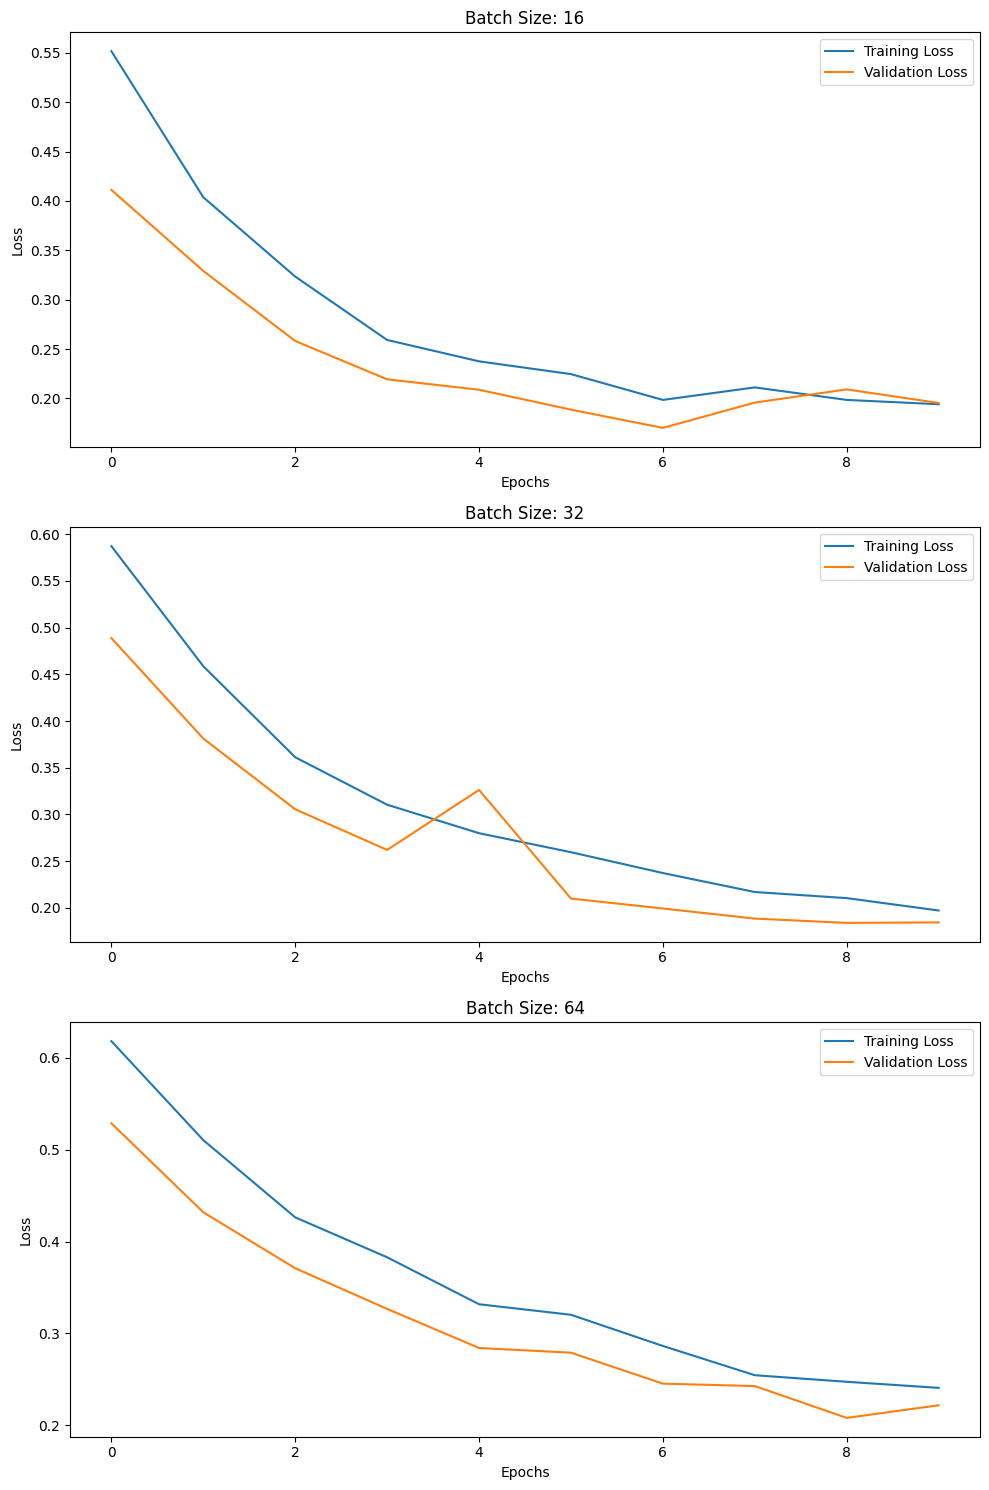

In [62]:
batch_sizes = [16, 32, 64]

losses_dict = {}

for batch_size in batch_sizes:
    train_data = TensorDataset(train_seq, train_mask, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    val_data = TensorDataset(val_seq, val_mask, val_y)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

    model = Ext_Arch(pretrained_model)
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=0.0001)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    cross_entropy = nn.NLLLoss(weight=weights)

    epochs = 10
    best_valid_loss = float('inf')

    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

        train_loss, _ = train()
        valid_loss, _ = evaluate()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'saved_weights_bs_{batch_size}.pt')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')

    losses_dict[batch_size] = {'train': train_losses, 'valid': valid_losses}

fig, axs = plt.subplots(len(batch_sizes), 1, figsize=(10, 15))
for i, batch_size in enumerate(batch_sizes):
    axs[i].plot(losses_dict[batch_size]['train'], label='Training Loss')
    axs[i].plot(losses_dict[batch_size]['valid'], label='Validation Loss')
    axs[i].set_title(f'Batch Size: {batch_size}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()

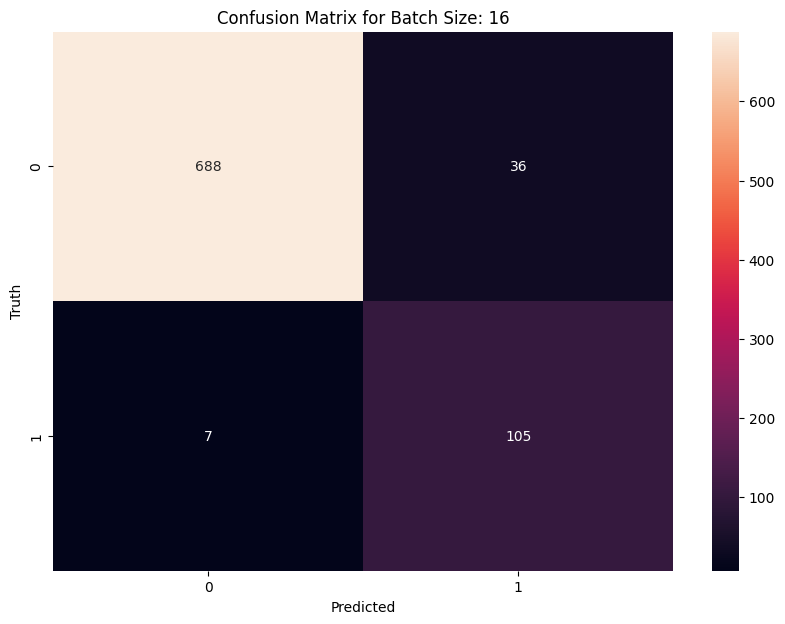


Classification Report for Batch Size: 16
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       724
           1       0.74      0.94      0.83       112

    accuracy                           0.95       836
   macro avg       0.87      0.94      0.90       836
weighted avg       0.96      0.95      0.95       836



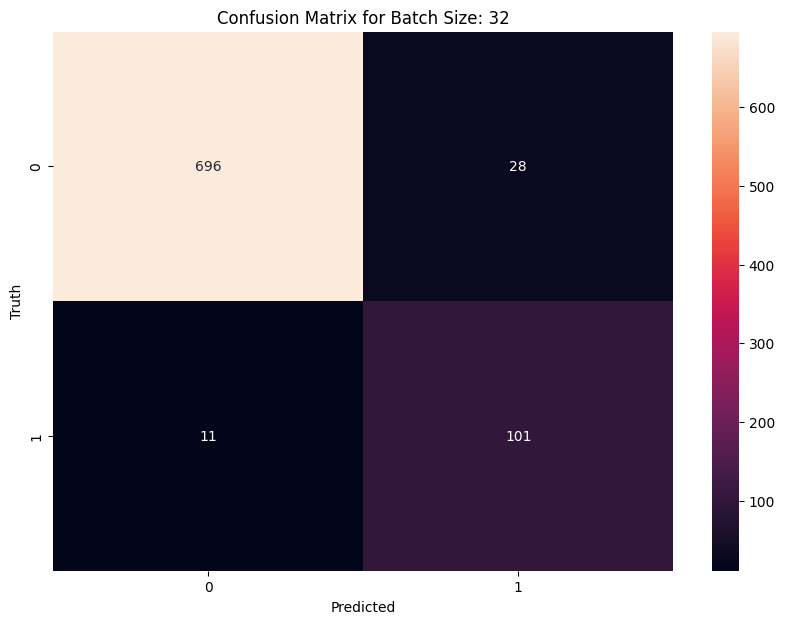


Classification Report for Batch Size: 32
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       724
           1       0.78      0.90      0.84       112

    accuracy                           0.95       836
   macro avg       0.88      0.93      0.91       836
weighted avg       0.96      0.95      0.95       836



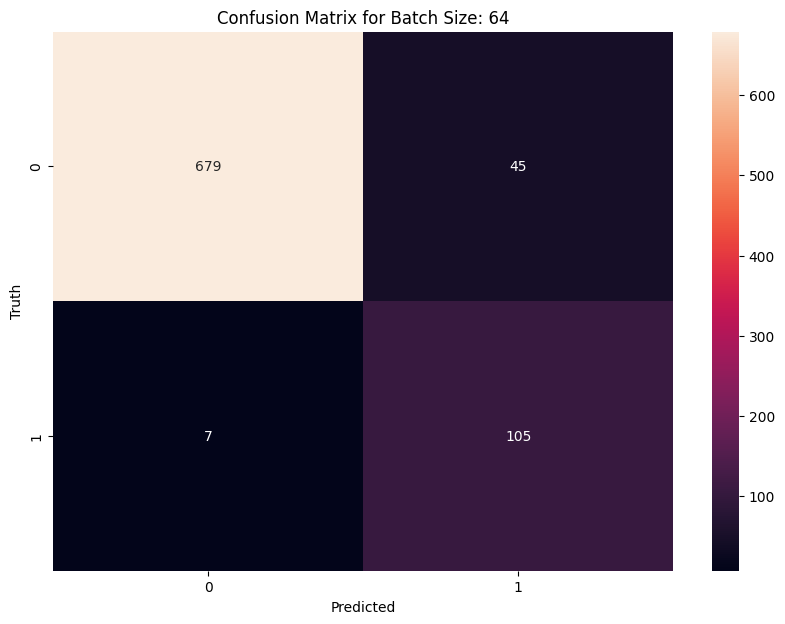


Classification Report for Batch Size: 64
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       724
           1       0.70      0.94      0.80       112

    accuracy                           0.94       836
   macro avg       0.84      0.94      0.88       836
weighted avg       0.95      0.94      0.94       836



In [22]:
batch_sizes = [16, 32, 64]

for batch_size in batch_sizes:
    path = f'saved_weights_bs_{batch_size}.pt'
    model.load_state_dict(torch.load(path))

    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
        preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis=1)

    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"Confusion Matrix for Batch Size: {batch_size}")
    plt.show()

    print(f"\nClassification Report for Batch Size: {batch_size}")
    print(classification_report(test_y, preds))

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.593
Validation Loss: 0.492

 Epoch 2 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.452
Validation Loss: 0.393

 Epoch 3 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.371
Validation Loss: 0.314

 Epoch 4 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.310
Validation Loss: 0.270

 Epoch 5 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.281
Validation Loss: 0.238

 Epoch 1 / 10


c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.598
Validation Loss: 0.488

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.452
Validation Loss: 0.377

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.375
Validation Loss: 0.307

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.329
Validation Loss: 0.288

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.273
Validation Loss: 0.238

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.241
Validation Loss: 0.233

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.229
Validation Loss: 0.200

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.205
Validation Loss: 0.185

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.600
Validation Loss: 0.488

 Epoch 2 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.453
Validation Loss: 0.374

 Epoch 3 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.367
Validation Loss: 0.307

 Epoch 4 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.311
Validation Loss: 0.313

 Epoch 5 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.278
Validation Loss: 0.246

 Epoch 6 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.249
Validation Loss: 0.226

 Epoch 7 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.229
Validation Loss: 0.204

 Epoch 8 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.215
Validation Loss: 0.189

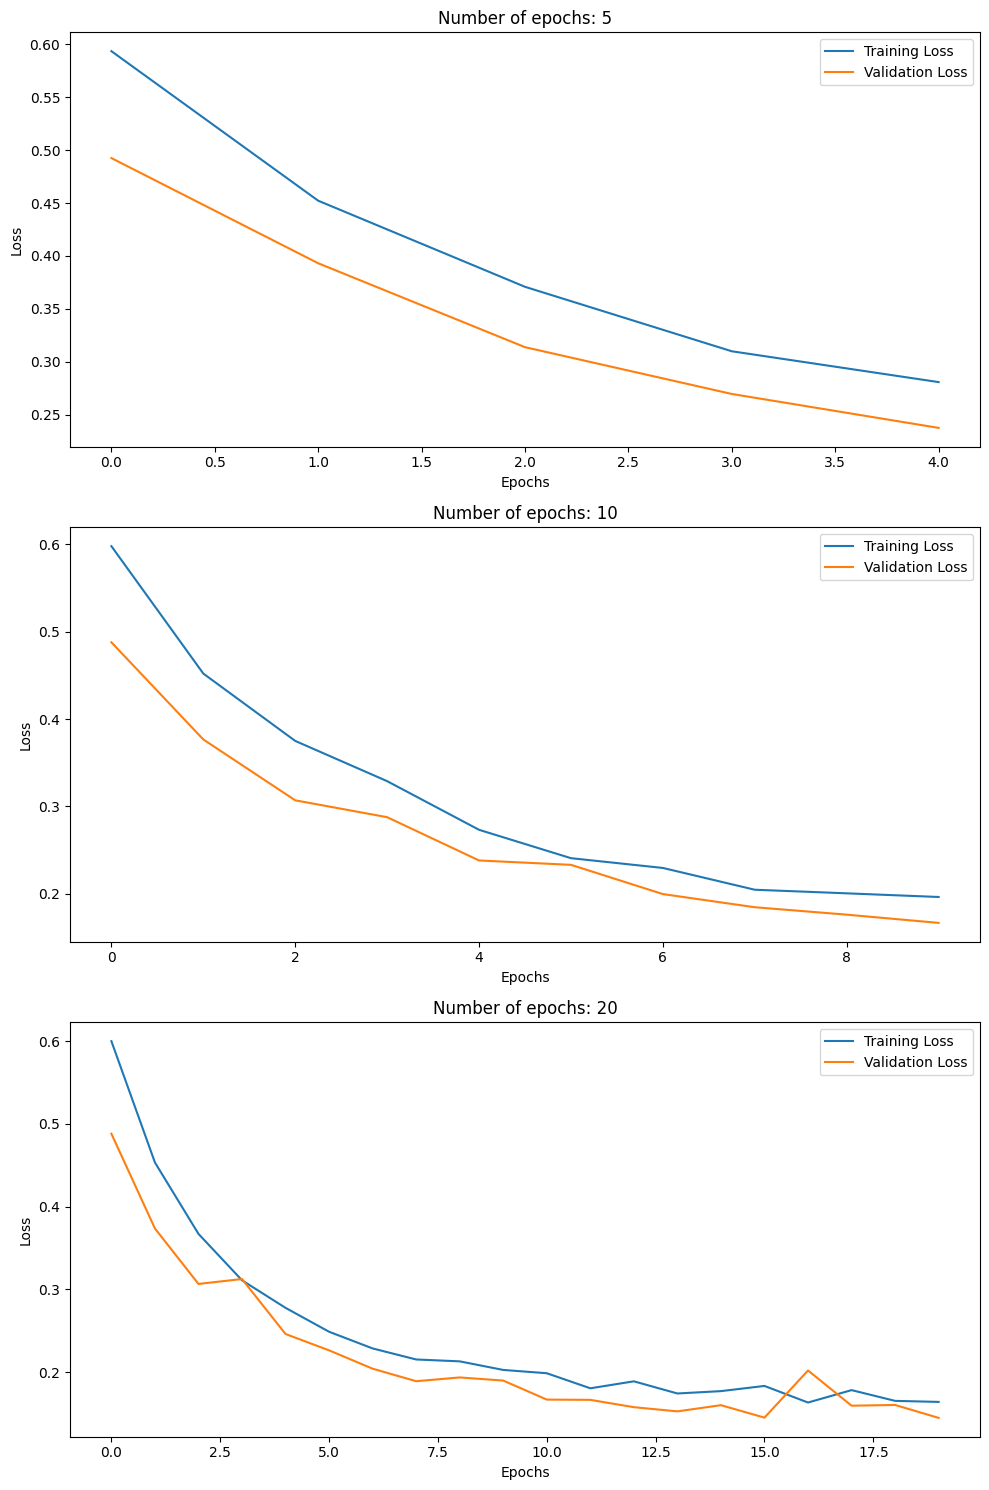

In [67]:
epoch_counts = [5, 10, 20]

batch_size = 32

losses_dict = {}

for epochs in epoch_counts:
    train_data = TensorDataset(train_seq, train_mask, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    val_data = TensorDataset(val_seq, val_mask, val_y)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

    model = Ext_Arch(pretrained_model)
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=0.0001)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    cross_entropy = nn.NLLLoss(weight=weights)

    best_valid_loss = float('inf')

    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

        train_loss, _ = train()
        valid_loss, _ = evaluate()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'saved_weights_epochs_{epochs}.pt')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')

    losses_dict[epochs] = {'train': train_losses, 'valid': valid_losses}

fig, axs = plt.subplots(len(epoch_counts), 1, figsize=(10, 15))
for i, epochs in enumerate(epoch_counts):
    axs[i].plot(losses_dict[epochs]['train'], label='Training Loss')
    axs[i].plot(losses_dict[epochs]['valid'], label='Validation Loss')
    axs[i].set_title(f'Number of epochs: {epochs}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()


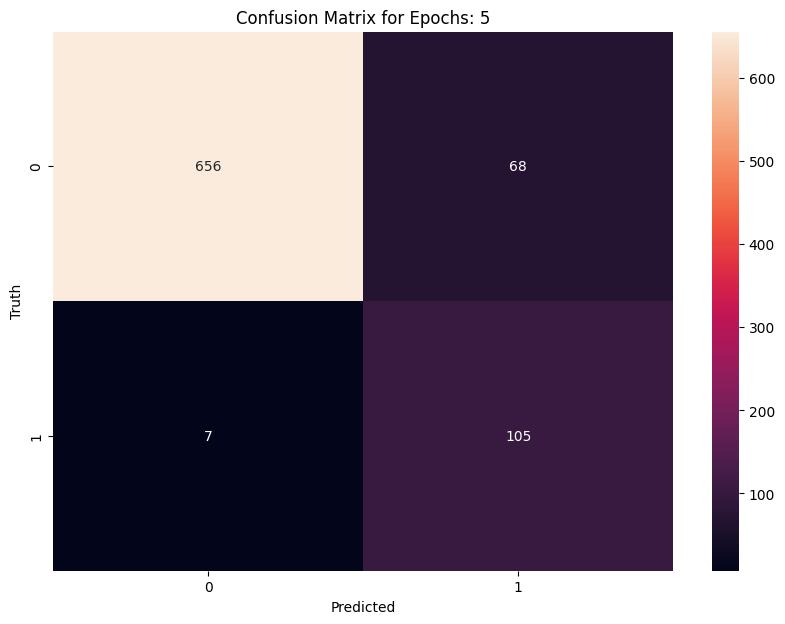


Classification Report for Epochs: 5
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       724
           1       0.61      0.94      0.74       112

    accuracy                           0.91       836
   macro avg       0.80      0.92      0.84       836
weighted avg       0.94      0.91      0.92       836



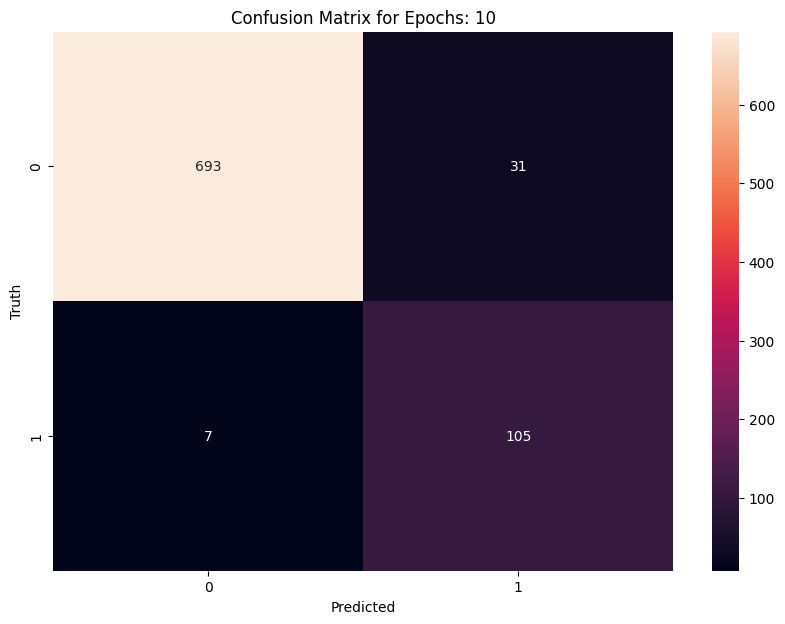


Classification Report for Epochs: 10
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       724
           1       0.77      0.94      0.85       112

    accuracy                           0.95       836
   macro avg       0.88      0.95      0.91       836
weighted avg       0.96      0.95      0.96       836



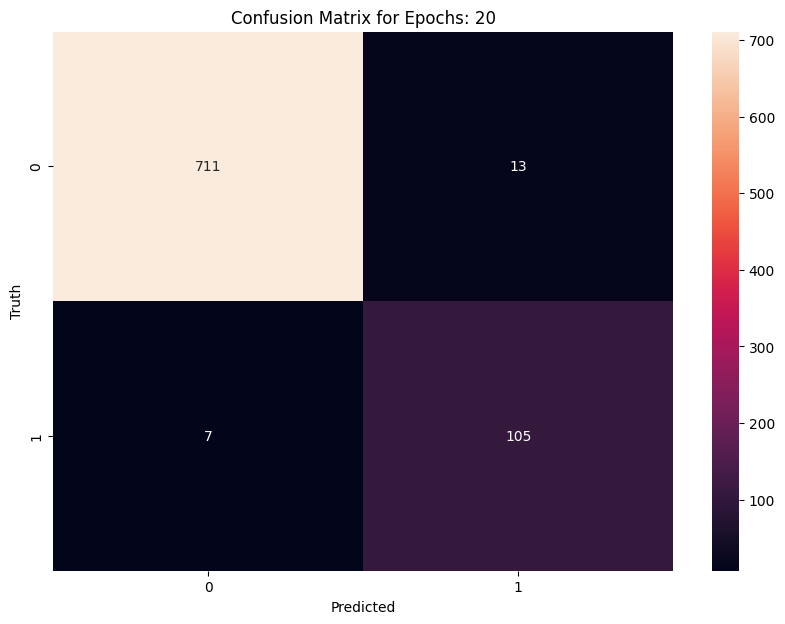


Classification Report for Epochs: 20
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       724
           1       0.89      0.94      0.91       112

    accuracy                           0.98       836
   macro avg       0.94      0.96      0.95       836
weighted avg       0.98      0.98      0.98       836



In [23]:
epoch_counts = [5, 10, 20]

for epochs in epoch_counts:
    path = f'saved_weights_epochs_{epochs}.pt'
    model.load_state_dict(torch.load(path))

    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
        preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis=1)

    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"Confusion Matrix for Epochs: {epochs}")
    plt.show()

    print(f"\nClassification Report for Epochs: {epochs}")
    print(classification_report(test_y, preds))

Zadanie 3,4

In [24]:
class Ext_Arch_Large(nn.Module):

    def __init__(self, pretrained_model, device):
        super(Ext_Arch_Large, self).__init__()

        self.pretrained_model = pretrained_model.to(device)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        # Create temporary tensors on the same device as the model
        temp_input_ids = torch.randint(0, 1000, (1, 512)).to(device)
        temp_mask = torch.ones((1, 512)).to(device)

        with torch.no_grad():
            # Ensuring the model is on the correct device
            model_output_size = self.pretrained_model(temp_input_ids, attention_mask=temp_mask)[0].shape[-1]

        self.fc1 = nn.Linear(model_output_size, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        # Pass inputs through the pretrained model
        model_output = self.pretrained_model(sent_id, attention_mask=mask)

        # Extract the last hidden states (the main model output)
        hidden_states = model_output.last_hidden_state if hasattr(model_output, 'last_hidden_state') else model_output[0]

        # Get the hidden state of the [CLS] token
        cls_hs = hidden_states[:, 0]

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [25]:
losses_dict = {}

In [ ]:
import pickle

epochs = 10

model_identifiers = {
    # 'albert_base' : 'albert-base-v1',
    # 'xlnet_base': 'xlnet-base-cased',
    # 'albert_large' : 'albert-xxlarge-v2',
    'xlnet_large': 'xlnet-large-cased'
}

for architecture in model_identifiers:
    if architecture == 'xlnet_base':
        pretrained_model = XLNetModel.from_pretrained(model_identifiers[architecture])
        tokenizer = AutoTokenizer.from_pretrained(model_identifiers[architecture])
        model = Ext_Arch_Large(pretrained_model,device).to(device)
    elif architecture == 'albert_base':
        pretrained_model = AlbertModel.from_pretrained(model_identifiers[architecture])
        tokenizer = AutoTokenizer.from_pretrained(model_identifiers[architecture])
        model = Ext_Arch(pretrained_model).to(device)
    elif architecture == 'xlnet_large':
        device = 'cpu'
        pretrained_model = XLNetModel.from_pretrained(model_identifiers[architecture])
        tokenizer = AutoTokenizer.from_pretrained(model_identifiers[architecture])
        model = Ext_Arch_Large(pretrained_model, device).to(device)
    elif architecture == 'albert_large':
        pretrained_model = AlbertModel.from_pretrained(model_identifiers[architecture])
        tokenizer = AutoTokenizer.from_pretrained(model_identifiers[architecture])
        model = Ext_Arch_Large(pretrained_model, device).to(device)

    for param in pretrained_model.parameters():
        param.requires_grad = False

    tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding='max_length',
    truncation=True
    )

    tokens_val = tokenizer.batch_encode_plus(
        val_text.tolist(),
        max_length = 25,
        padding='max_length',
        truncation=True
    )

    tokens_test = tokenizer.batch_encode_plus(
        test_text.tolist(),
        max_length = 25,
        padding='max_length',
        truncation=True
    )

    train_seq = torch.tensor(tokens_train['input_ids'])
    train_mask = torch.tensor(tokens_train['attention_mask'])
    train_y = torch.tensor(train_labels.tolist())

    val_seq = torch.tensor(tokens_val['input_ids'])
    val_mask = torch.tensor(tokens_val['attention_mask'])
    val_y = torch.tensor(val_labels.tolist())

    test_seq = torch.tensor(tokens_test['input_ids'])
    test_mask = torch.tensor(tokens_test['attention_mask'])
    test_y = torch.tensor(test_labels.tolist())

    batch_size = 8

    train_data = TensorDataset(train_seq, train_mask, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    val_data = TensorDataset(val_seq, val_mask, val_y)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
    
    optimizer = AdamW(model.parameters(), lr=0.00001)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    cross_entropy = nn.NLLLoss(weight=weights)

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs} - {architecture.upper()}')
        train_loss, _ = train()
        valid_loss, _ = evaluate()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'saved_weights_{architecture}.pt')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    losses_dict[architecture] = {'train': train_losses, 'valid': valid_losses}

    with open('losses_dict_all_architectures.pkl', 'wb') as file:
        pickle.dump(losses_dict, file)


In [31]:
with open('losses_dict_all_architectures.pkl', 'rb') as file:
    losses_dict = pickle.load(file)

# Print the contents of the dictionary
for architecture, losses in losses_dict.items():
    print(f"\nArchitecture: {architecture}")
    print("Training Losses:", losses['train'])
    print("Validation Losses:", losses['valid'])


Architecture: albert_base
Training Losses: [0.5319321140585864, 0.42967425127987, 0.4122609580928063, 0.388517014754814, 0.3720715890378981, 0.3847026854455776, 0.37537079632137216, 0.37462935410630815, 0.3496147587028958, 0.3386753388312187]
Validation Losses: [0.5003422177263669, 0.4544996405641238, 0.4381426673914705, 0.446040337284406, 0.47815815491513125, 0.4267400752841717, 0.5226093388739086, 0.42698926673758597, 0.4294661902246021, 0.42634034229087686]

Architecture: xlnet_base
Training Losses: [0.5864416249707097, 0.41117120001342944, 0.34897704678969305, 0.330737384707957, 0.34125994819504607, 0.30993494709388764, 0.29742149404559254, 0.3186213951815515, 0.3104232629080261, 0.2876243632106439]
Validation Losses: [0.3833853964294706, 0.3493909500849744, 0.3161529303838809, 0.31013771415732444, 0.30781400825695265, 0.32143133827401993, 0.34581735378402906, 0.356616258248964, 0.34015100481226995, 0.3495113126936693]

Architecture: albert_large
Training Losses: [0.52970371041141

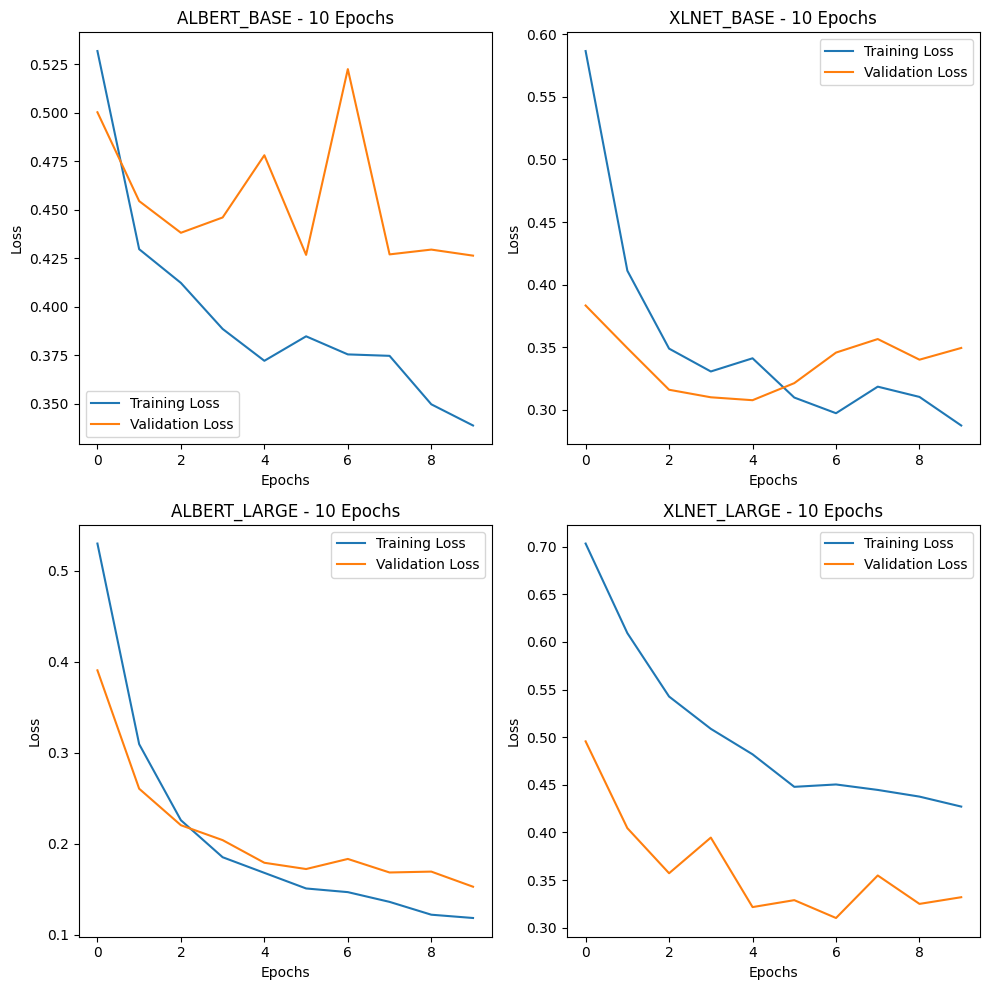

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, (architecture, losses) in enumerate(losses_dict.items()):
    row, col = i // 2, i % 2 
    axs[row, col].plot(losses['train'], label='Training Loss')
    axs[row, col].plot(losses['valid'], label='Validation Loss')
    axs[row, col].set_title(f'{architecture.upper()} - 10 Epochs')
    axs[row, col].set_xlabel('Epochs')
    axs[row, col].set_ylabel('Loss')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


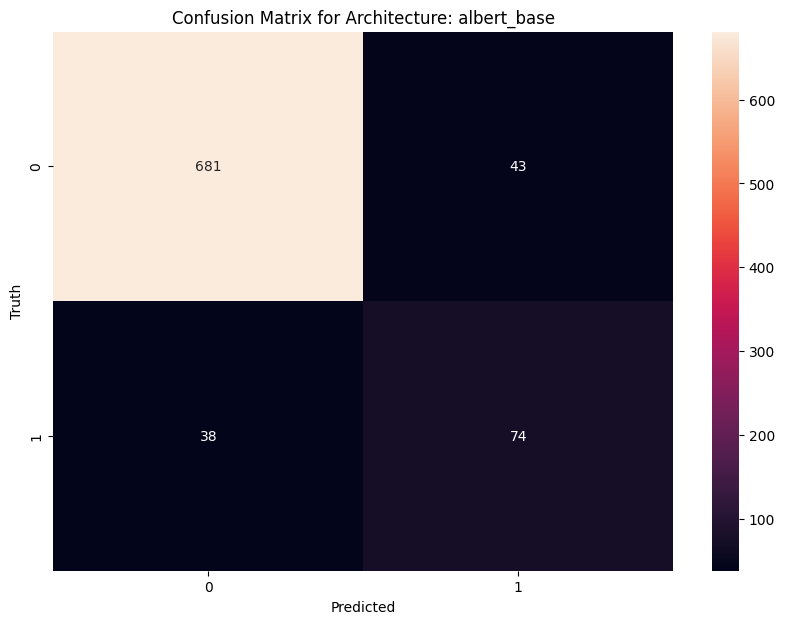


Classification Report for Architecture: albert_base
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       724
           1       0.63      0.66      0.65       112

    accuracy                           0.90       836
   macro avg       0.79      0.80      0.80       836
weighted avg       0.90      0.90      0.90       836



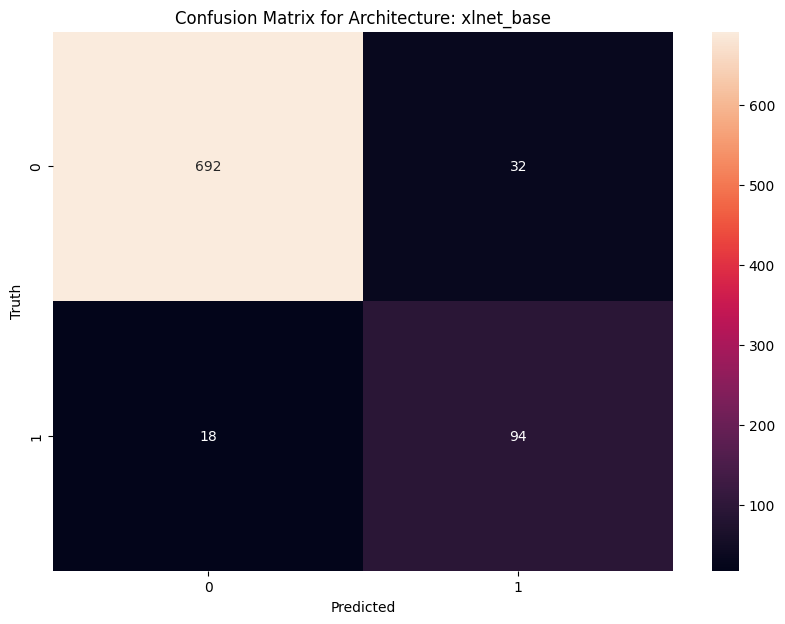


Classification Report for Architecture: xlnet_base
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       724
           1       0.75      0.84      0.79       112

    accuracy                           0.94       836
   macro avg       0.86      0.90      0.88       836
weighted avg       0.94      0.94      0.94       836



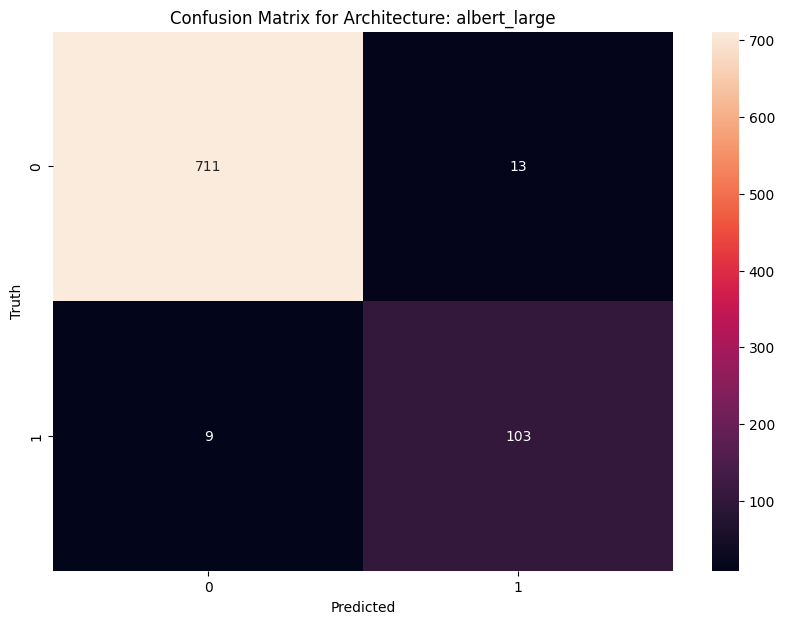


Classification Report for Architecture: albert_large
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       724
           1       0.89      0.92      0.90       112

    accuracy                           0.97       836
   macro avg       0.94      0.95      0.94       836
weighted avg       0.97      0.97      0.97       836



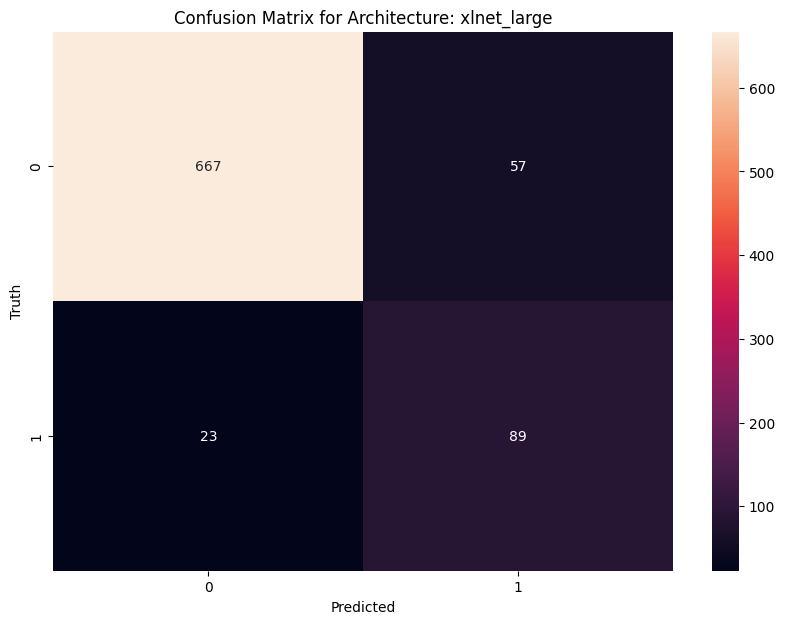


Classification Report for Architecture: xlnet_large
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       724
           1       0.61      0.79      0.69       112

    accuracy                           0.90       836
   macro avg       0.79      0.86      0.82       836
weighted avg       0.92      0.90      0.91       836



In [35]:
model_identifiers = {
    'albert_base' : 'albert-base-v1',
    'xlnet_base': 'xlnet-base-cased',
    'albert_large' : 'albert-xxlarge-v2',
    'xlnet_large': 'xlnet-large-cased'
}

for (architecture, losses) in losses_dict.items():
    path = f'saved_weights_{architecture}.pt'

    if architecture == 'xlnet_base':
        pretrained_model = XLNetModel.from_pretrained(model_identifiers[architecture])
        tokenizer = AutoTokenizer.from_pretrained(model_identifiers[architecture])
        model = Ext_Arch_Large(pretrained_model,device).to(device)
    elif architecture == 'albert_base':
        pretrained_model = AlbertModel.from_pretrained(model_identifiers[architecture])
        tokenizer = AutoTokenizer.from_pretrained(model_identifiers[architecture])
        model = Ext_Arch(pretrained_model).to(device)
    elif architecture == 'xlnet_large':
        device = 'cpu'
        pretrained_model = XLNetModel.from_pretrained(model_identifiers[architecture])
        tokenizer = AutoTokenizer.from_pretrained(model_identifiers[architecture])
        model = Ext_Arch_Large(pretrained_model, device).to(device)
    elif architecture == 'albert_large':
        pretrained_model = AlbertModel.from_pretrained(model_identifiers[architecture])
        tokenizer = AutoTokenizer.from_pretrained(model_identifiers[architecture])
        model = Ext_Arch_Large(pretrained_model, device).to(device)

    tokens_test = tokenizer.batch_encode_plus(
        test_text.tolist(),
        max_length = 25,
        padding='max_length',
        truncation=True
    )

    test_seq = torch.tensor(tokens_test['input_ids'])
    test_mask = torch.tensor(tokens_test['attention_mask'])
    test_y = torch.tensor(test_labels.tolist())

    model.load_state_dict(torch.load(path, map_location=device))

    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
        preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis=1)

    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"Confusion Matrix for Architecture: {architecture}")
    plt.show()

    print(f"\nClassification Report for Architecture: {architecture}")
    print(classification_report(test_y, preds))

Zadanie 5, 6

In [45]:
class Modified_Ext_Arch(nn.Module):

    def __init__(self, pretrained_model):
        super(Modified_Ext_Arch, self).__init__()
        self.pretrained_model = pretrained_model

        self.dropout = nn.Dropout(0.3)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.01)

        self.fc1 = nn.Linear(768, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 2)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        model_output = self.pretrained_model(sent_id, attention_mask=mask, return_dict=False)
        cls_hs = model_output[0][:, 0] if isinstance(model_output, tuple) else model_output[:, 0]

        x = self.fc1(cls_hs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)

        x = self.dropout(x)

        x = self.fc3(x)

        x = self.softmax(x)

        return x


In [46]:
class DeepResidual_Ext_Arch(nn.Module):
    def __init__(self, pretrained_model):
        super(DeepResidual_Ext_Arch, self).__init__()

        self.pretrained_model = pretrained_model

        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 512)  
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 2)   
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        model_output = self.pretrained_model(sent_id, attention_mask=mask, return_dict=False)
        cls_hs = model_output[0][:, 0] if isinstance(model_output, tuple) else model_output[:, 0]
        
        x = self.fc1(cls_hs)
        identity = x  
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x += identity 

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.softmax(x)

        return x

In [47]:
class Attention_Ext_Arch(nn.Module):
    def __init__(self, pretrained_model):
        super(Attention_Ext_Arch, self).__init__()

        self.pretrained_model = pretrained_model

        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=4)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        model_output = self.pretrained_model(sent_id, attention_mask=mask, return_dict=False)
        cls_hs = model_output[0][:, 0] if isinstance(model_output, tuple) else model_output[:, 0]
        
        attn_output, _ = self.attention(cls_hs.unsqueeze(0), cls_hs.unsqueeze(0), cls_hs.unsqueeze(0))
        attn_output = attn_output.squeeze(0)

        x = self.fc1(attn_output)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [54]:
modified = Modified_Ext_Arch(pretrained_model)
residual = DeepResidual_Ext_Arch(pretrained_model)
attention = Attention_Ext_Arch(pretrained_model)

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Epoch 1 / 10
  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50  of    105.
  Batch   100  of    105.

Training Loss: 0.203
Validation Loss: 0.092

 Epoch 2 / 10
  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50  of    105.
  Batch   100  of    105.

Training Loss: 0.201
Validation Loss: 0.097

 Epoch 3 / 10
  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50 

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50  of    105.
  Batch   100  of    105.

Training Loss: 0.516
Validation Loss: 0.337

 Epoch 2 / 10
  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50  of    105.
  Batch   100  of    105.

Training Loss: 0.265
Validation Loss: 0.170

 Epoch 3 / 10
  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50  of    105.
  B

c:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\Semestr2\lista-5-9-15-11-00-Iga-Miller\.venv\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50  of    105.
  Batch   100  of    105.

Training Loss: 0.508
Validation Loss: 0.273

 Epoch 2 / 10
  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50  of    105.
  Batch   100  of    105.

Training Loss: 0.184
Validation Loss: 0.203

 Epoch 3 / 10
  Batch    50  of    488.
  Batch   100  of    488.
  Batch   150  of    488.
  Batch   200  of    488.
  Batch   250  of    488.
  Batch   300  of    488.
  Batch   350  of    488.
  Batch   400  of    488.
  Batch   450  of    488.

Evaluating...
  Batch    50  of    105.
  B

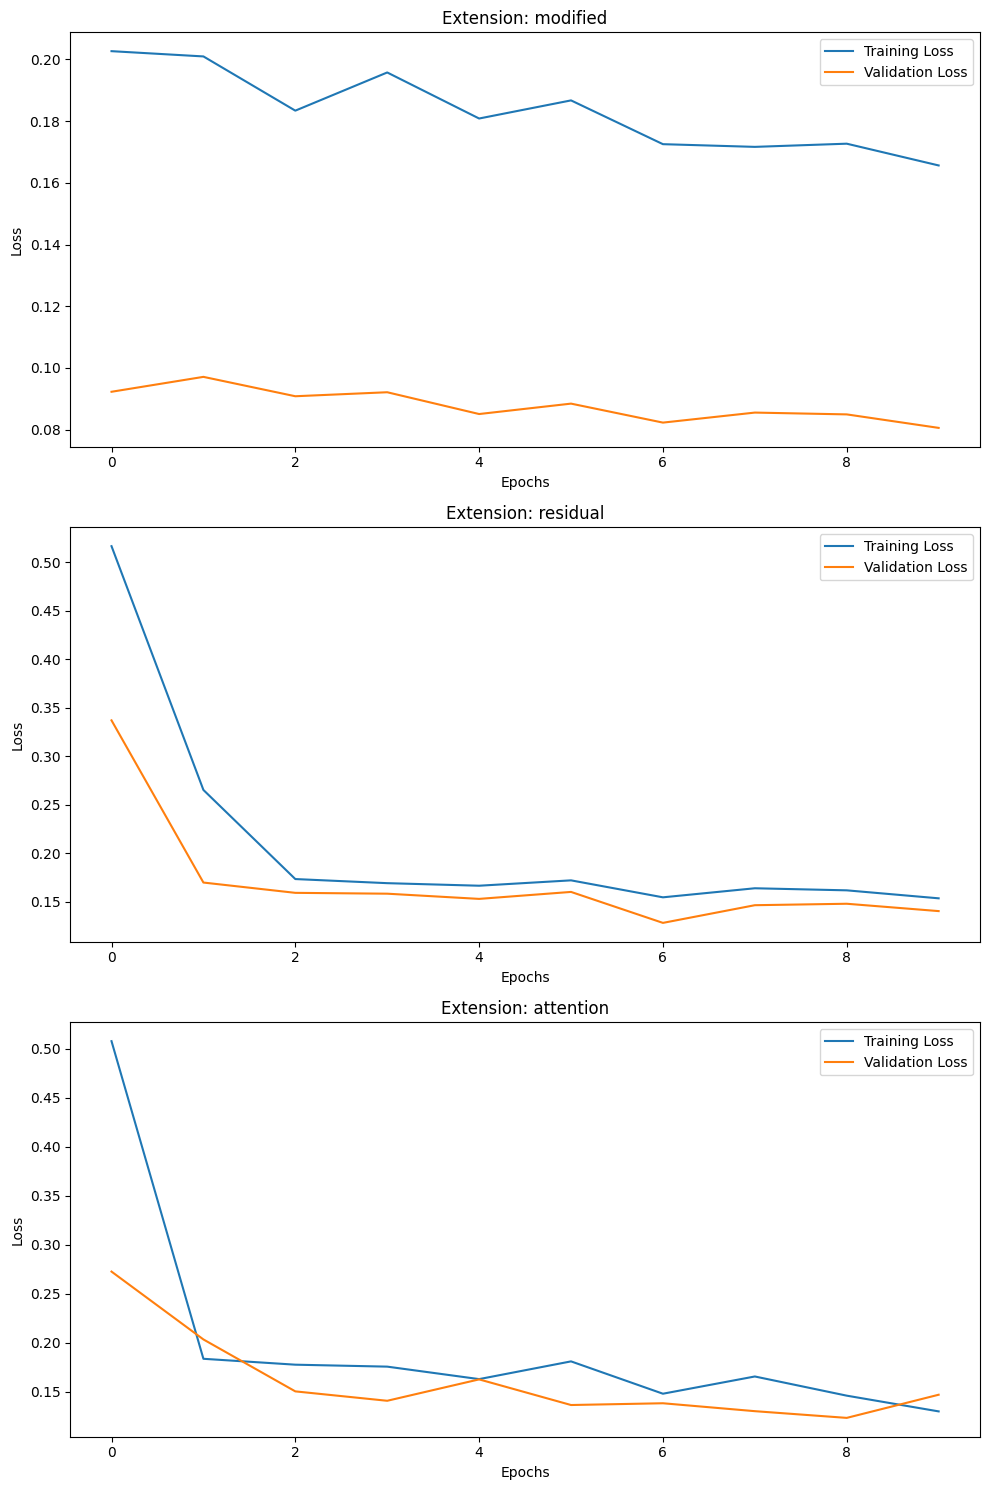

In [56]:
losses_dict = {}

model_names = ['modified', 'residual', 'attention']

models = [modified, residual, attention]
for model, model_name in zip(models, model_names):
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=0.00001)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    cross_entropy = nn.NLLLoss(weight=weights)

    epochs = 10
    best_valid_loss = float('inf')

    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

        train_loss, _ = train()
        valid_loss, _ = evaluate()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss

            torch.save(model.state_dict(), f'saved_weights_extension_{model_name}.pt')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')

    losses_dict[model_name] = {'train': train_losses, 'valid': valid_losses}

fig, axs = plt.subplots(len(models), 1, figsize=(10, 15))
for i, model_name in enumerate(model_names):
    axs[i].plot(losses_dict[model_name]['train'], label='Training Loss')
    axs[i].plot(losses_dict[model_name]['valid'], label='Validation Loss')
    axs[i].set_title(f'Extension: {model_name}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()


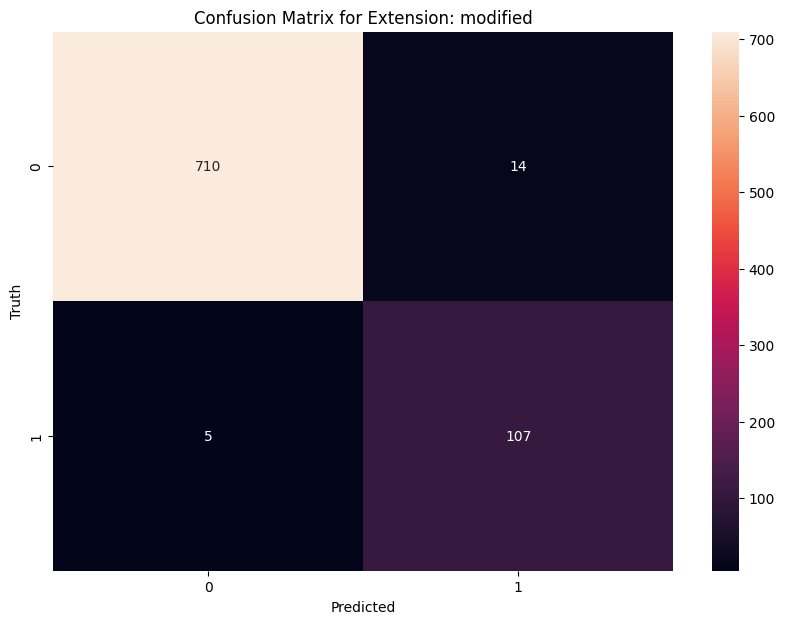


Classification Report for Extension: modified
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       724
           1       0.88      0.96      0.92       112

    accuracy                           0.98       836
   macro avg       0.94      0.97      0.95       836
weighted avg       0.98      0.98      0.98       836



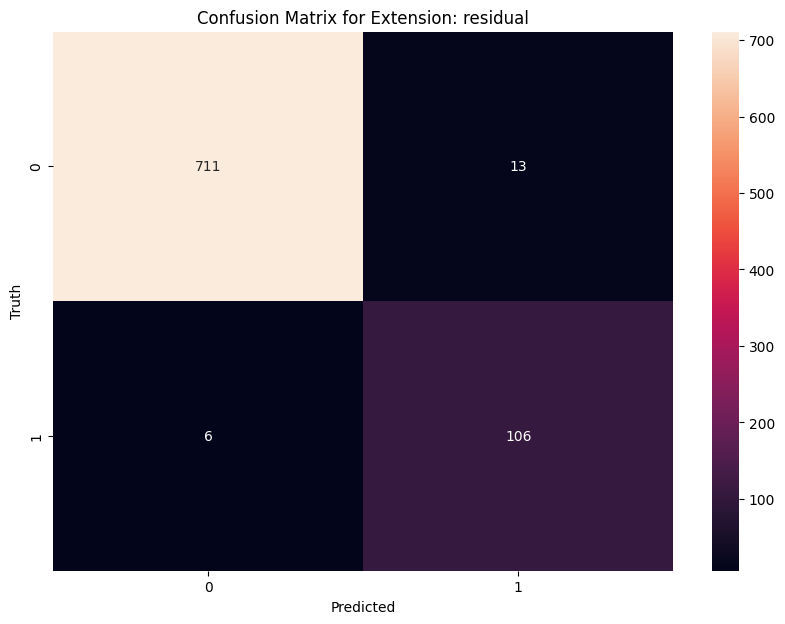


Classification Report for Extension: residual
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       724
           1       0.89      0.95      0.92       112

    accuracy                           0.98       836
   macro avg       0.94      0.96      0.95       836
weighted avg       0.98      0.98      0.98       836



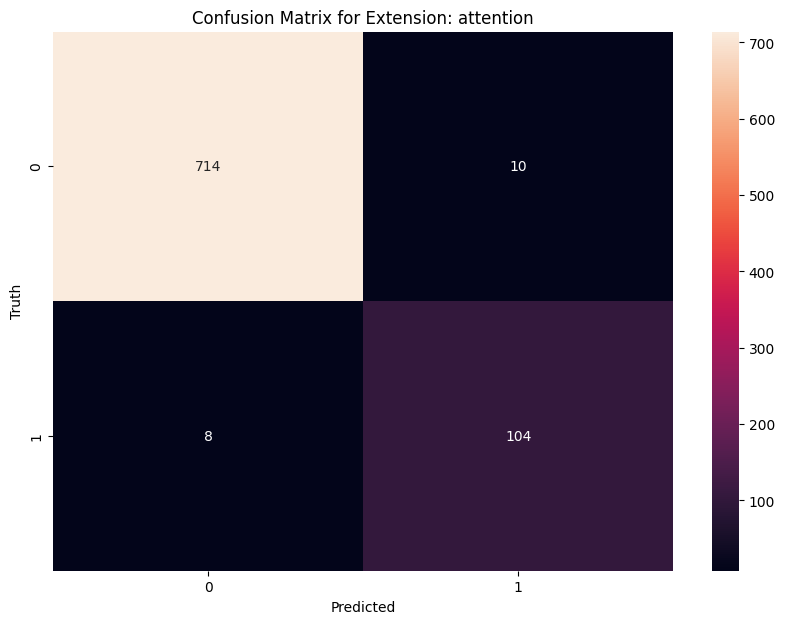


Classification Report for Extension: attention
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.91      0.93      0.92       112

    accuracy                           0.98       836
   macro avg       0.95      0.96      0.95       836
weighted avg       0.98      0.98      0.98       836



In [57]:
model_names = ['modified', 'residual', 'attention']
models = [modified, residual, attention]

for model, model_name in zip(models, model_names):
    path = f'saved_weights_extension_{model_name}.pt'
    model.load_state_dict(torch.load(path))

    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
        preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis=1)

    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"Confusion Matrix for Extension: {model_name}")
    plt.show()

    print(f"\nClassification Report for Extension: {model_name}")
    print(classification_report(test_y, preds))

Zadanie 7

In [60]:
def tokenize_data(model_name, texts, max_length, padding_strategy):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokens = tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        padding=padding_strategy,
        truncation=True
    )
    return torch.tensor(tokens['input_ids']), torch.tensor(tokens['attention_mask'])

model_identifiers = {
    'bert_base': 'bert-base-uncased',
    'albert_base' : 'albert-base-v1',
    'xlnet_base': 'xlnet-base-cased',
}

losses_dict = {}

max_length_list = [20,50,100]
padding_strategy_list = ['max_length', 'max_length-10']

for max_length in max_length_list:

    for architecture in model_identifiers:
        if architecture == 'bert_base':
            pretrained_model = AutoModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch(pretrained_model).to(device)
        elif architecture == 'albert_base':
            pretrained_model = AlbertModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch(pretrained_model).to(device)
        elif architecture == 'xlnet_base':
            pretrained_model = XLNetModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch_Large(pretrained_model, device).to(device)

        train_seq, train_mask = tokenize_data(model_identifiers[architecture], train_text, max_length, 'max_length')
        val_seq, val_mask = tokenize_data(model_identifiers[architecture], val_text, max_length, 'max_length')
        test_seq, test_mask = tokenize_data(model_identifiers[architecture], test_text, max_length, 'max_length')


        train_y = torch.tensor(train_labels.tolist())
        val_y = torch.tensor(val_labels.tolist())
        test_y = torch.tensor(test_labels.tolist())

        batch_size = 8

        train_data = TensorDataset(train_seq, train_mask, train_y)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
        val_data = TensorDataset(val_seq, val_mask, val_y)
        val_sampler = SequentialSampler(val_data)
        val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

        optimizer = AdamW(model.parameters(), lr=0.00001)
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
        weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        cross_entropy = nn.NLLLoss(weight=weights)

        best_valid_loss = float('inf')
        train_losses = []
        valid_losses = []

        epochs = 5

        for epoch in range(epochs):
            print(f'\nEpoch {epoch + 1}/{epochs} - {architecture.upper()} - max_length = {max_length}')
            train_loss, _ = train()
            valid_loss, _ = evaluate()

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), f'saved_weights_{architecture}_{max_length}.pt')

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

        losses_dict[f'{architecture}_len{max_length}'] = {'train': train_losses, 'valid': valid_losses}



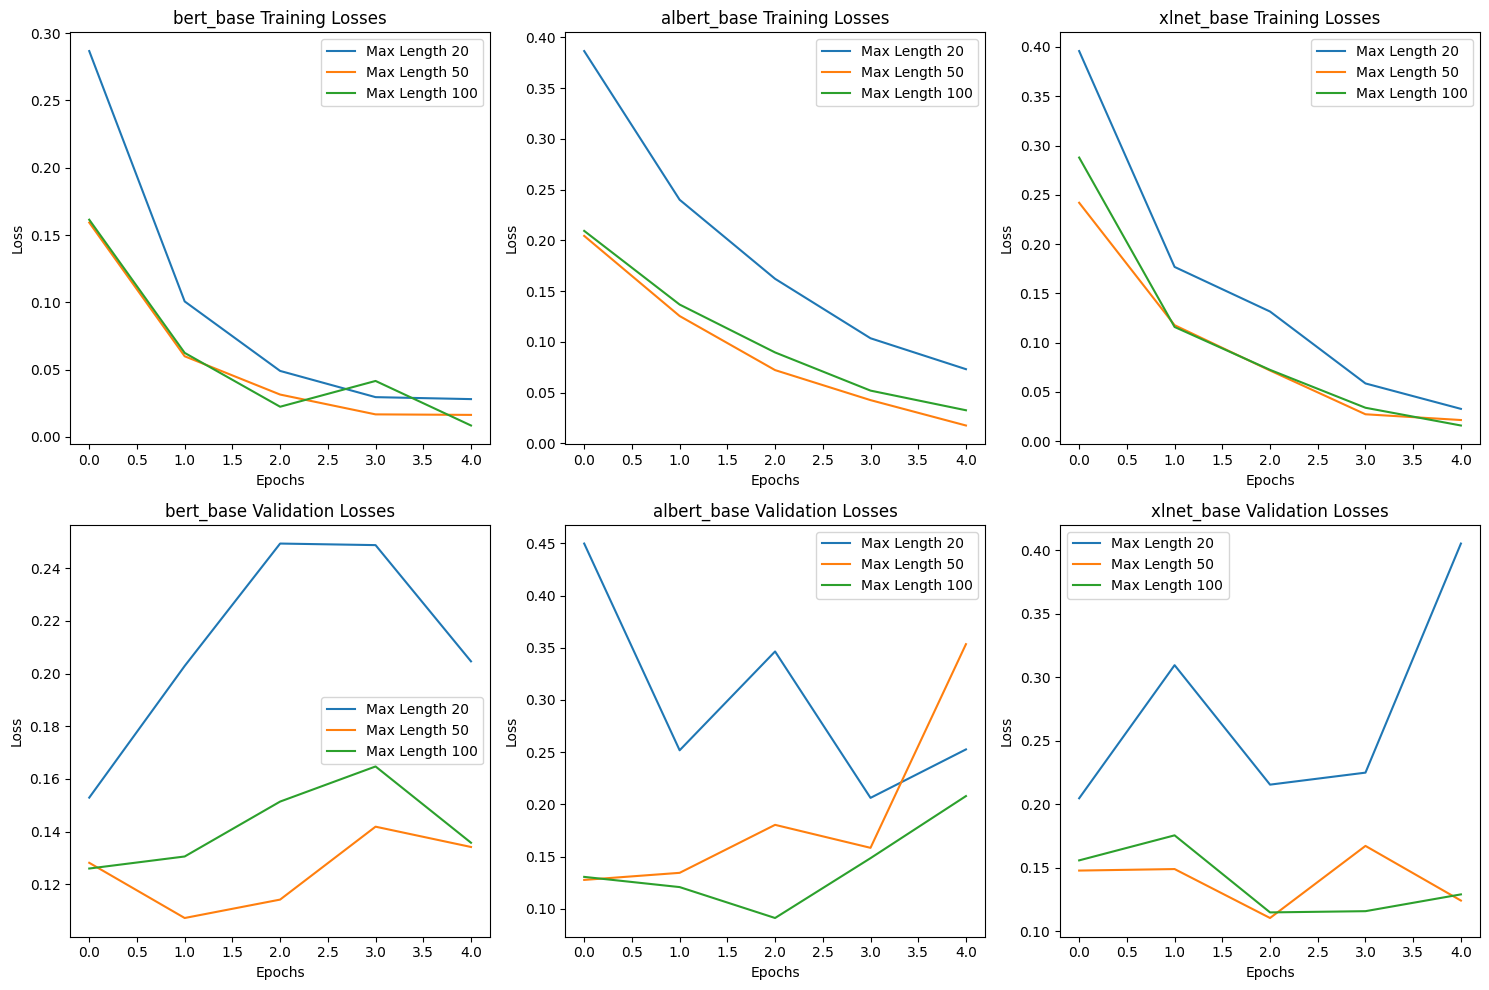

In [26]:
fig, axs = plt.subplots(2, len(model_identifiers), figsize=(15, 10))  # 2 rows, one for each architecture

for i, architecture in enumerate(model_identifiers):
    for max_length in max_length_list:
        key = f'{architecture}_len{max_length}'
        axs[0, i].plot(losses_dict[key]['train'], label=f'Max Length {max_length}')
        axs[1, i].plot(losses_dict[key]['valid'], label=f'Max Length {max_length}')

    axs[0, i].set_title(f'{architecture} Training Losses')
    axs[1, i].set_title(f'{architecture} Validation Losses')
    axs[0, i].set_xlabel('Epochs')
    axs[1, i].set_xlabel('Epochs')
    axs[0, i].set_ylabel('Loss')
    axs[1, i].set_ylabel('Loss')
    axs[0, i].legend()
    axs[1, i].legend()

plt.tight_layout()
plt.show()

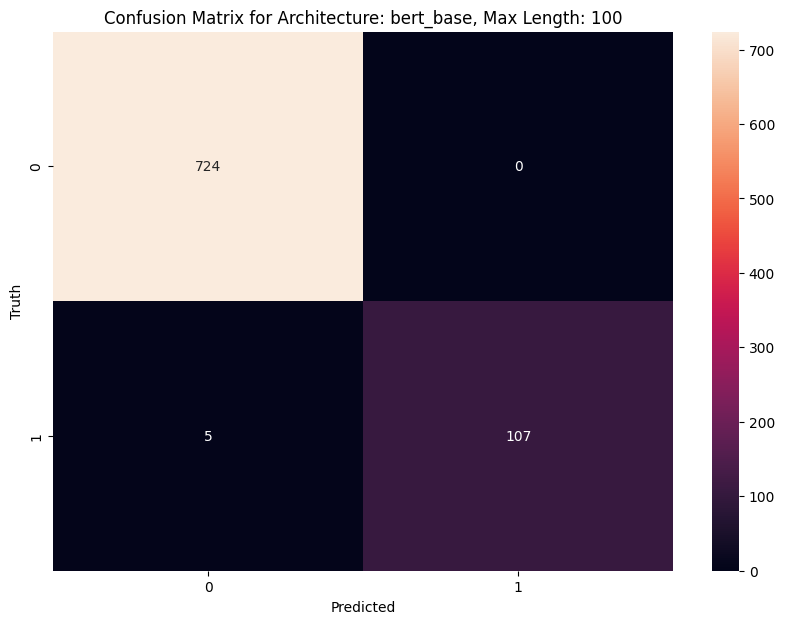


Best Classification Report for Architecture: bert_base, Max Length: 100
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       0.99      0.95      0.97       112

    accuracy                           0.99       836
   macro avg       0.99      0.97      0.98       836
weighted avg       0.99      0.99      0.99       836



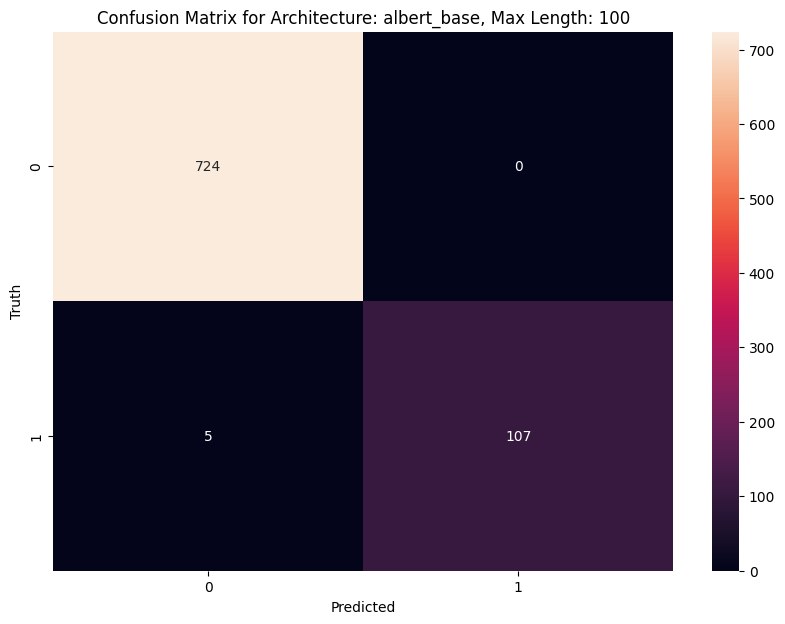


Best Classification Report for Architecture: albert_base, Max Length: 100
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.93      0.96      0.95       112

    accuracy                           0.99       836
   macro avg       0.96      0.98      0.97       836
weighted avg       0.99      0.99      0.99       836



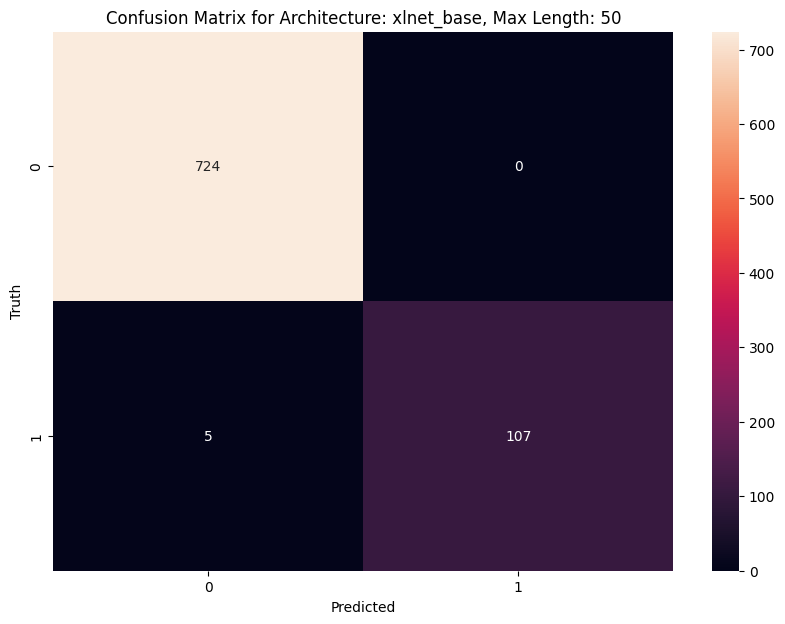


Best Classification Report for Architecture: xlnet_base, Max Length: 50
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       724
           1       0.98      0.97      0.98       112

    accuracy                           0.99       836
   macro avg       0.99      0.99      0.99       836
weighted avg       0.99      0.99      0.99       836



In [61]:
from sklearn.metrics import accuracy_score

model_identifiers = {
    'bert_base': 'bert-base-uncased',
    'albert_base' : 'albert-base-v1',
    'xlnet_base': 'xlnet-base-cased',
}

max_length_list = [20,50,100]

device = 'cpu'

best_accuracy_dict = {}

for max_length in max_length_list:
    for architecture in model_identifiers:
        if architecture == 'bert_base':
            pretrained_model = AutoModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch(pretrained_model).to(device)
        elif architecture == 'albert_base':
            pretrained_model = AlbertModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch(pretrained_model).to(device)
        elif architecture == 'xlnet_base':
            pretrained_model = XLNetModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch_Large(pretrained_model, device).to(device)
        
        train_seq, train_mask = tokenize_data(model_identifiers[architecture], train_text, max_length, 'max_length')
        val_seq, val_mask = tokenize_data(model_identifiers[architecture], val_text, max_length, 'max_length')
        test_seq, test_mask = tokenize_data(model_identifiers[architecture], test_text, max_length, 'max_length')


        train_y = torch.tensor(train_labels.tolist())
        val_y = torch.tensor(val_labels.tolist())
        test_y = torch.tensor(test_labels.tolist())

        batch_size = 8

        train_data = TensorDataset(train_seq, train_mask, train_y)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
        val_data = TensorDataset(val_seq, val_mask, val_y)
        val_sampler = SequentialSampler(val_data)
        val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

        path = f'saved_weights_{architecture}_{max_length}.pt'
        model.load_state_dict(torch.load(path, map_location=device))

        model.eval()
        with torch.no_grad():
            preds = model(test_seq.to(device), test_mask.to(device))
            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            accuracy = accuracy_score(test_y.cpu(), preds)

        if architecture not in best_accuracy_dict or accuracy > best_accuracy_dict[architecture]['accuracy']:
            best_accuracy_dict[architecture] = {'accuracy': accuracy, 'max_length': max_length, 'report': classification_report(test_y.cpu(), preds)}


for architecture, info in best_accuracy_dict.items():
    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"Confusion Matrix for Architecture: {architecture}, Max Length: {info['max_length']}")
    plt.show()
    print(f"\nBest Classification Report for Architecture: {architecture}, Max Length: {info['max_length']}")
    print(info['report'])



        

In [ ]:
def tokenize_data(model_name, texts, max_length, padding_strategy):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokens = tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        padding=padding_strategy,
        truncation=True
    )
    return torch.tensor(tokens['input_ids']), torch.tensor(tokens['attention_mask'])

model_identifiers = {
    'bert_base': 'bert-base-uncased',
    'albert_base' : 'albert-base-v1',
    'xlnet_base': 'xlnet-base-cased',
}

losses_dict = {}

max_length_list = [20,50,100]
padding_strategy_list = ['longest', 'max_length']

device = 'cuda'

for padding in padding_strategy_list:

    for architecture in model_identifiers:
        if architecture == 'bert_base':
            pretrained_model = AutoModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch(pretrained_model).to(device)
        elif architecture == 'albert_base':
            pretrained_model = AlbertModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch(pretrained_model).to(device)
        elif architecture == 'xlnet_base':
            pretrained_model = XLNetModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch_Large(pretrained_model, device).to(device)

        train_seq, train_mask = tokenize_data(model_identifiers[architecture], train_text, 100, padding)
        val_seq, val_mask = tokenize_data(model_identifiers[architecture], val_text, 100, padding)
        test_seq, test_mask = tokenize_data(model_identifiers[architecture], test_text, 100, padding)


        train_y = torch.tensor(train_labels.tolist())
        val_y = torch.tensor(val_labels.tolist())
        test_y = torch.tensor(test_labels.tolist())

        batch_size = 8

        train_data = TensorDataset(train_seq, train_mask, train_y)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
        val_data = TensorDataset(val_seq, val_mask, val_y)
        val_sampler = SequentialSampler(val_data)
        val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

        optimizer = AdamW(model.parameters(), lr=0.00001)
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
        weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        cross_entropy = nn.NLLLoss(weight=weights)

        best_valid_loss = float('inf')
        train_losses = []
        valid_losses = []

        epochs = 5

        for epoch in range(epochs):
            print(f'\nEpoch {epoch + 1}/{epochs} - {architecture.upper()} - padding = {padding}')
            train_loss, _ = train()
            valid_loss, _ = evaluate()

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), f'saved_weights_{architecture}_{padding}.pt')

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

        losses_dict[f'{architecture}_{padding}'] = {'train': train_losses, 'valid': valid_losses}



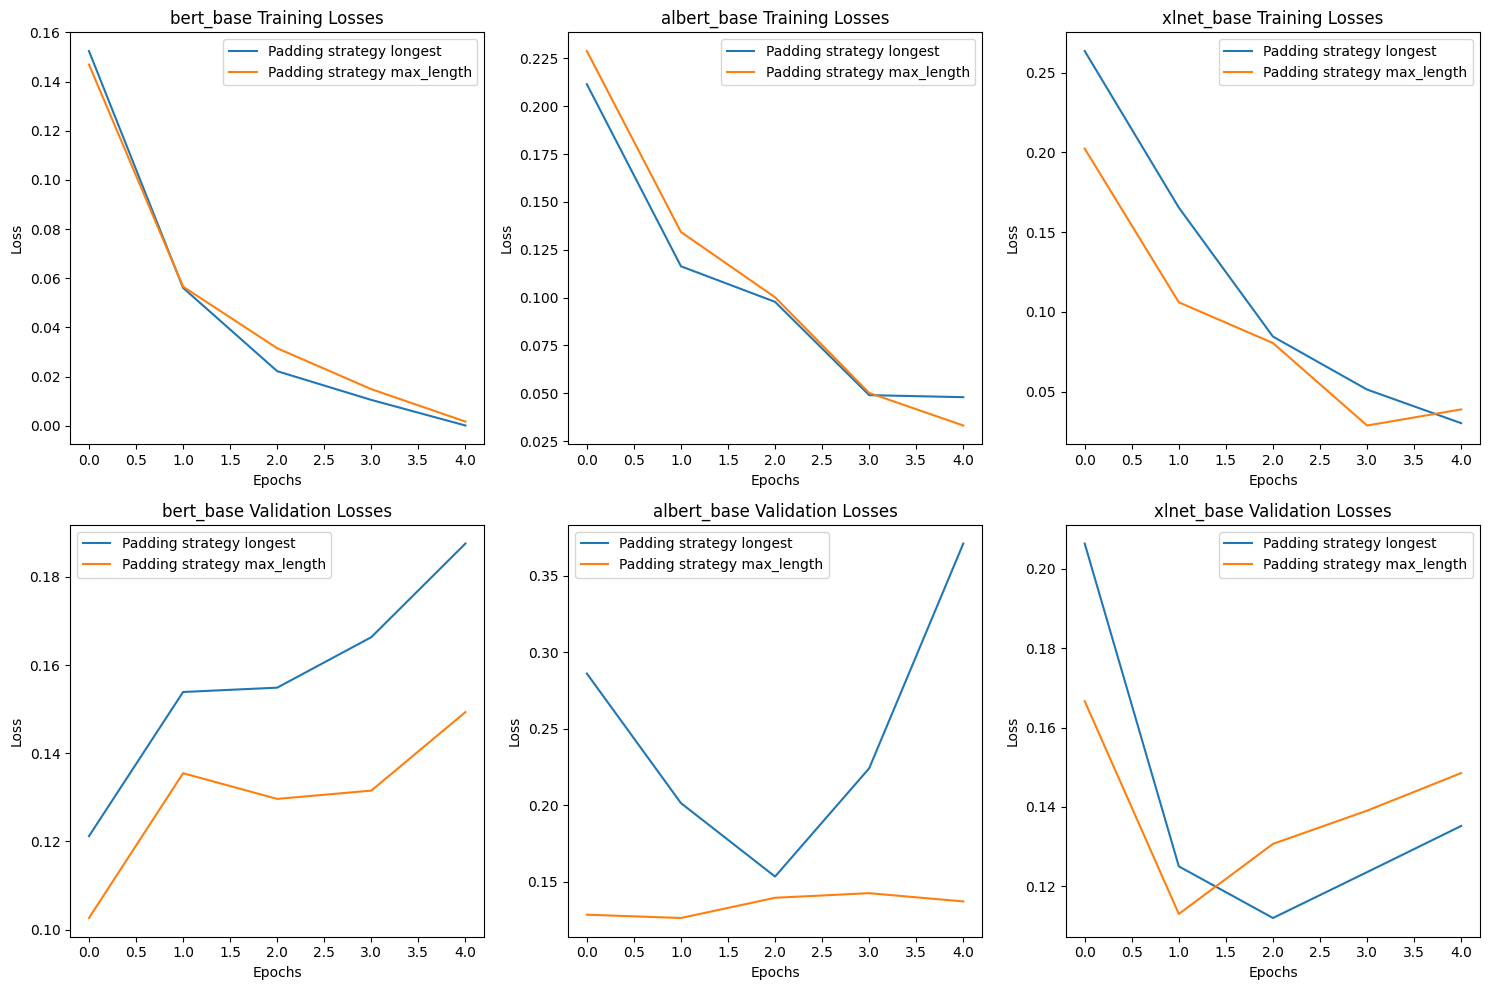

In [21]:
fig, axs = plt.subplots(2, len(model_identifiers), figsize=(15, 10))  # 2 rows, one for each architecture

for i, architecture in enumerate(model_identifiers):
    for padding in padding_strategy_list:
        key = f'{architecture}_{padding}'
        axs[0, i].plot(losses_dict[key]['train'], label=f'Padding strategy {padding}')
        axs[1, i].plot(losses_dict[key]['valid'], label=f'Padding strategy {padding}')

    axs[0, i].set_title(f'{architecture} Training Losses')
    axs[1, i].set_title(f'{architecture} Validation Losses')
    axs[0, i].set_xlabel('Epochs')
    axs[1, i].set_xlabel('Epochs')
    axs[0, i].set_ylabel('Loss')
    axs[1, i].set_ylabel('Loss')
    axs[0, i].legend()
    axs[1, i].legend()

plt.tight_layout()
plt.show()

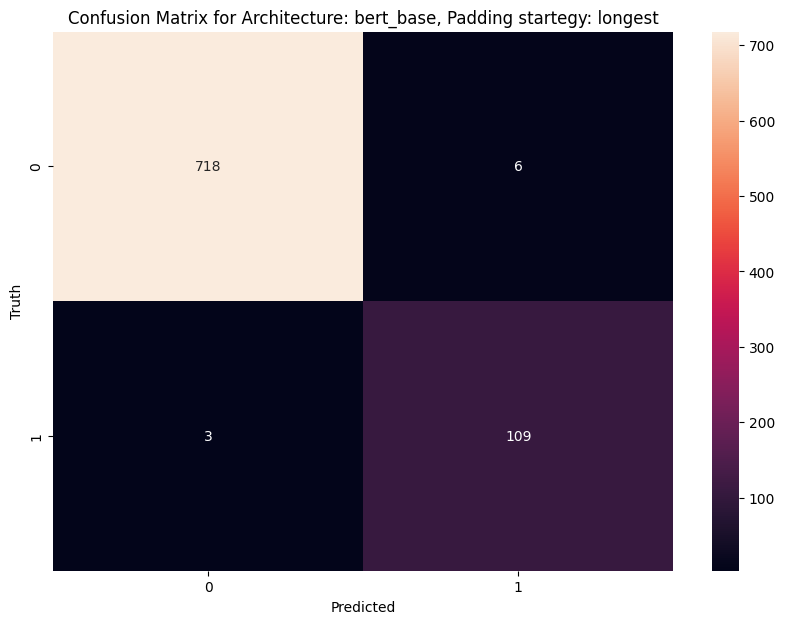


Best Classification Report for Architecture: bert_base, Padding startegy: longest
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       724
           1       0.96      0.97      0.97       112

    accuracy                           0.99       836
   macro avg       0.98      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



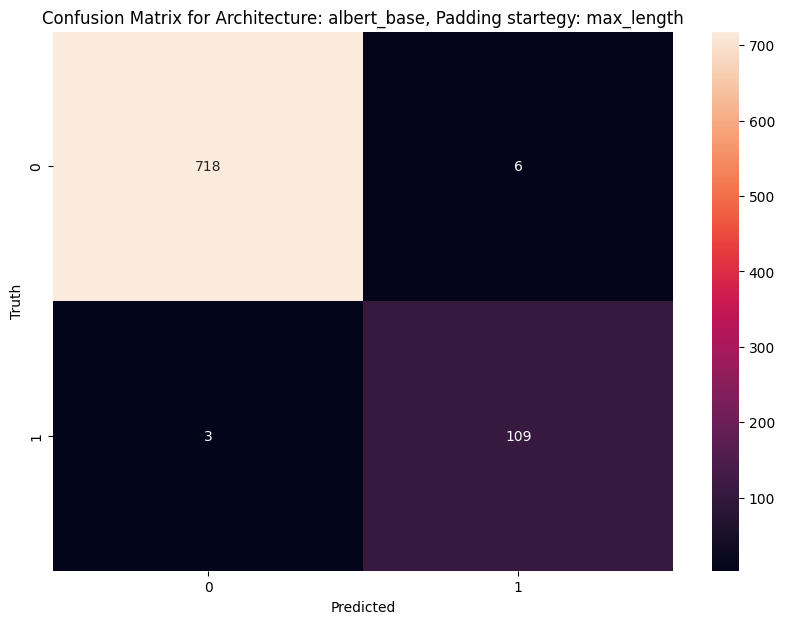


Best Classification Report for Architecture: albert_base, Padding startegy: max_length
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.96      0.96      0.96       112

    accuracy                           0.99       836
   macro avg       0.98      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



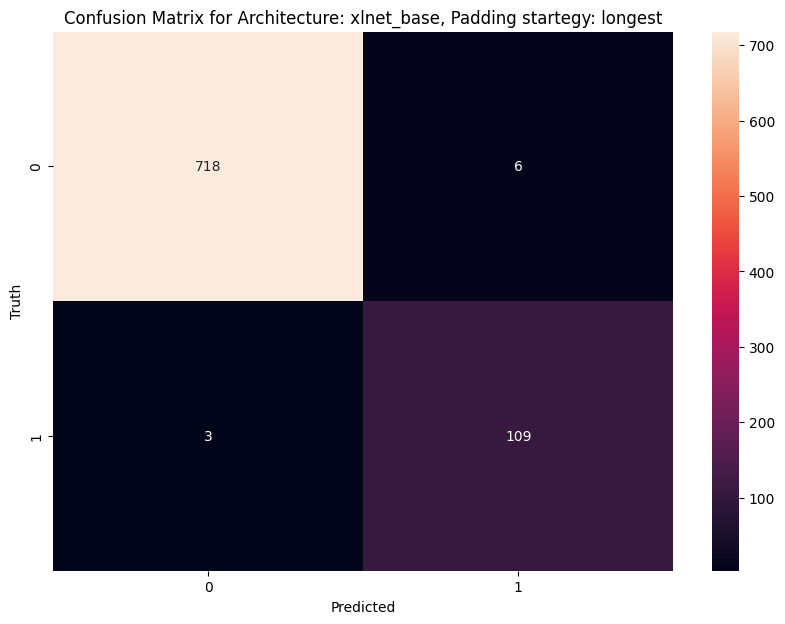


Best Classification Report for Architecture: xlnet_base, Padding startegy: longest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       724
           1       0.98      0.96      0.97       112

    accuracy                           0.99       836
   macro avg       0.99      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



In [63]:
best_accuracy_dict = {}

device = 'cpu'

padding_strategy_list = ['longest', 'max_length']

for padding in padding_strategy_list:
    for architecture in model_identifiers:
        if architecture == 'bert_base':
            pretrained_model = AutoModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch(pretrained_model).to(device)
        elif architecture == 'albert_base':
            pretrained_model = AlbertModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch(pretrained_model).to(device)
        elif architecture == 'xlnet_base':
            pretrained_model = XLNetModel.from_pretrained(model_identifiers[architecture])
            model = Ext_Arch_Large(pretrained_model, device).to(device)
        
        train_seq, train_mask = tokenize_data(model_identifiers[architecture], train_text, 100, padding)
        val_seq, val_mask = tokenize_data(model_identifiers[architecture], val_text, 100, padding)
        test_seq, test_mask = tokenize_data(model_identifiers[architecture], test_text, 100, padding)


        train_y = torch.tensor(train_labels.tolist())
        val_y = torch.tensor(val_labels.tolist())
        test_y = torch.tensor(test_labels.tolist())

        batch_size = 8

        train_data = TensorDataset(train_seq, train_mask, train_y)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
        val_data = TensorDataset(val_seq, val_mask, val_y)
        val_sampler = SequentialSampler(val_data)
        val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

        path = f'saved_weights_{architecture}_{padding}.pt'
        model.load_state_dict(torch.load(path, map_location=device))

        model.eval()
        with torch.no_grad():
            preds = model(test_seq.to(device), test_mask.to(device))
            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            accuracy = accuracy_score(test_y.cpu(), preds)

        if architecture not in best_accuracy_dict or accuracy > best_accuracy_dict[architecture]['accuracy']:
            best_accuracy_dict[architecture] = {'accuracy': accuracy, 'padding': padding, 'report': classification_report(test_y.cpu(), preds)}

for architecture, info in best_accuracy_dict.items():
    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"Confusion Matrix for Architecture: {architecture}, Padding startegy: {info['padding']}")
    plt.show()
    print(f"\nBest Classification Report for Architecture: {architecture}, Padding startegy: {info['padding']}")
    print(info['report'])
